## Dataset description

In [777]:
import datetime as dt

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.colors as mtcol

import statsmodels.api as sm
import scipy.stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

trips_df = pd.read_csv('MavenRail.csv')

In [779]:
#check for the folder existence
import pathlib
pathlib.Path('Figures').mkdir(exist_ok = True)

#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [781]:
#dataframe description
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31645 entries, 0 to 31644
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Payment.Method     31645 non-null  object
 1   Railcard           10734 non-null  object
 2   Ticket.Class       31645 non-null  object
 3   Ticket.Type        31645 non-null  object
 4   Price              31645 non-null  int64 
 5   Departure.Station  31645 non-null  object
 6   Arrival.Station    31645 non-null  object
 7   Departure          31642 non-null  object
 8   Scheduled.Arrival  31641 non-null  object
 9   Actual.Arrival     29765 non-null  object
 10  Journey.Status     31645 non-null  object
 11  Reason.for.Delay   4166 non-null   object
 12  Refund.Request     31645 non-null  object
dtypes: int64(1), object(12)
memory usage: 3.1+ MB


In [783]:
trips_df.head()

Payment.Method Railcard Ticket.Class Ticket.Type  Price  \
0    Contactless    Adult     Standard     Advance     43   
1    Credit Card    Adult     Standard     Advance     23   
2    Credit Card      NaN     Standard     Advance      3   
3    Credit Card      NaN     Standard     Advance     13   
4    Contactless      NaN     Standard     Advance     76   

       Departure.Station        Arrival.Station         Departure  \
0      London Paddington  Liverpool Lime Street  2024-01-01 11:00   
1     London Kings Cross                   York  2024-01-01 09:45   
2  Liverpool Lime Street  Manchester Piccadilly  2024-01-02 18:15   
3      London Paddington                Reading  2024-01-01 21:30   
4  Liverpool Lime Street          London Euston  2024-01-01 16:45   

  Scheduled.Arrival    Actual.Arrival Journey.Status Reason.for.Delay  \
0  2024-01-01 13:30  2024-01-01 13:30        On Time              NaN   
1  2024-01-01 11:35  2024-01-01 11:40        Delayed   Signal Failure   
2  2024-01-02 18:45  2024-01-02 18:45        On Time              NaN   
3  2024-01-01 22:30  2024-01-01 22:30        On Time              NaN   
4  2024-01-01 19:00  2024-01-01 19:00        On Time              NaN   

  Refund.Request  
0             No  
1             No  
2             No  
3             No  
4             No

In [785]:
trips_df['Payment.Method'].value_counts()

Payment.Method
Credit Card    19133
Contactless    10832
Debit Card      1680
Name: count, dtype: int64

In [787]:
trips_df['Railcard'].fillna('None').value_counts()

Railcard
None        20911
Adult        4845
Disabled     3089
Senior       2800
Name: count, dtype: int64

In [789]:
trips_df['Ticket.Class'].value_counts()

Ticket.Class
Standard       28588
First Class     3057
Name: count, dtype: int64

In [791]:
trips_df['Ticket.Type'].value_counts()

Ticket.Type
Advance     17557
Off-Peak     8748
Anytime      5340
Name: count, dtype: int64

In [2208]:
#displays relevant dataset-related metrics
print('The dataset stores data on', trips_df['Departure.Station'].nunique(), 'departure stations and',
      trips_df['Arrival.Station'].nunique(), 'arrival destinations,',
      len(list(filter(lambda x: x not in trips_df['Departure.Station'].unique(), trips_df['Arrival.Station'].unique()))),
      'of which have no records for return trips.',
      '\n' + 'The total number of unique routes is',
      str((trips_df['Departure.Station'] + trips_df['Arrival.Station']).nunique()) + '.')

The dataset stores data on 12 departure stations and 32 arrival destinations, 20 of which have no records for return trips. 
The total number of unique routes is 65.


In [795]:
#datetime feature processing 
trips_df['Departure'] = pd.to_datetime(trips_df['Departure'], format = '%Y-%m-%d %H:%M')
trips_df['Scheduled.Arrival'] = pd.to_datetime(trips_df['Scheduled.Arrival'], format = '%Y-%m-%d %H:%M')
trips_df['Actual.Arrival'] = pd.to_datetime(trips_df['Actual.Arrival'], format = '%Y-%m-%d %H:%M')

In [797]:
print('Rail journeys span a period from', trips_df['Departure'].min().strftime('%Y-%m-%d'),
      'to', trips_df['Departure'].max().strftime('%Y-%m-%d') + '.')

Rail journeys span a period from 2024-01-01 to 2024-04-30.


In [799]:
trips_df['Journey.Status'].value_counts()

Journey.Status
On Time      27479
Delayed       2289
Cancelled     1877
Name: count, dtype: int64

In [801]:
trips_df['Reason.for.Delay'].fillna('None').value_counts()

Reason.for.Delay
None               27479
Weather             1372
Signal Failure       968
Technical Issue      706
Staffing             407
Staff                399
Traffic              314
Name: count, dtype: int64

In [803]:
trips_df['Refund.Request'].value_counts()/trips_df.shape[0]

Refund.Request
No     0.964797
Yes    0.035203
Name: count, dtype: float64

## Preprocessing and EDA

In [806]:
#functions for imputation of missing or inaccurate values in departure and arrival columns
def impute_departure(df, ref_df = trips_df):

    if df['Departure'] != df['Departure'] and df['Scheduled.Arrival'] == df['Scheduled.Arrival']:
        dep = df['Departure.Station']
        arr = df['Arrival.Station']
        try:
            return df['Scheduled.Arrival'] - dt.timedelta(seconds = (ref_df.query('`Departure.Station` == @dep & `Arrival.Station` == @arr')
                       [['Scheduled.Arrival', 'Departure']].dropna()
                            .assign(duration = (trips_df['Scheduled.Arrival'] - trips_df['Departure']) 
                                    .dt.total_seconds()).query('duration > 0')['duration'].mean()))
        except:
            return df['Departure']
    else:
        return df['Departure']

def impute_arrival(df, ref_df = trips_df):

    if (df['Scheduled.Arrival'] != df['Scheduled.Arrival'] and df['Departure'] == df['Departure']) \
        or df['Scheduled.Arrival'] < df['Departure']:
        dep = df['Departure.Station']
        arr = df['Arrival.Station']
        try:
            return df['Departure'] + dt.timedelta(seconds = (ref_df.query('`Departure.Station` == @dep & `Arrival.Station` == @arr')
                       [['Scheduled.Arrival', 'Departure']].dropna()
                           .assign(duration = (trips_df['Scheduled.Arrival'] - trips_df['Departure'])
                                   .dt.total_seconds()).query('duration > 0')['duration'].mean()))
        except:
            return df['Scheduled.Arrival']
    else:
        return df['Scheduled.Arrival']

In [808]:
#perform imputation

trips_df['Departure'] = trips_df.apply(lambda x: impute_departure(x), axis = 1)
trips_df['Scheduled.Arrival'] = trips_df.apply(lambda x: impute_arrival(x), axis = 1)

trips_df.dropna(subset = ['Departure', 'Scheduled.Arrival'], inplace = True)
trips_df.reset_index(drop = True, inplace = True)

In [809]:
#feature engineering and extraction

trips_df['Travel.Duration'] = (trips_df['Scheduled.Arrival'] - trips_df['Departure']).dt.total_seconds()/60
trips_df['Travel.Delay'] = (trips_df['Actual.Arrival'] - trips_df['Scheduled.Arrival']).dt.total_seconds()/60
trips_df['Travel.Delay.Share'] = trips_df['Travel.Delay']/trips_df['Travel.Duration']

trips_df['Departure.Month'] = trips_df['Departure'].dt.month.astype('Int64')
trips_df['Departure.Weekday'] = trips_df['Departure'].dt.weekday.astype('Int64') + 1
trips_df['Departure.Weekend'] = np.where(trips_df['Departure.Weekday'].isin([6, 7]), True, False)
trips_df['Departure.Daytime'] = trips_df['Departure'].dt.hour.astype('Int64')

trips_df['Actual.Arrival.Daytime'] = trips_df['Actual.Arrival'].dt.hour.astype('Int64')
trips_df['Scheduled.Arrival.Daytime'] = trips_df['Scheduled.Arrival'].dt.hour.astype('Int64')

conditions_d = [trips_df['Departure.Daytime'].between(0, 5),
                trips_df['Departure.Daytime'].between(6, 11),
                trips_df['Departure.Daytime'].between(12, 17),
                trips_df['Departure.Daytime'].between(18, 23)]
conditions_a = [trips_df['Actual.Arrival.Daytime'].between(0, 5).fillna(False),
                trips_df['Actual.Arrival.Daytime'].between(6, 11).fillna(False),
                trips_df['Actual.Arrival.Daytime'].between(12, 17).fillna(False),
                trips_df['Actual.Arrival.Daytime'].between(18, 23).fillna(False)]
conditions_s = [trips_df['Scheduled.Arrival.Daytime'].between(0, 5).fillna(False),
                trips_df['Scheduled.Arrival.Daytime'].between(6, 11).fillna(False),
                trips_df['Scheduled.Arrival.Daytime'].between(12, 17).fillna(False),
                trips_df['Scheduled.Arrival.Daytime'].between(18, 23).fillna(False)]

daytime = ['Night', 'Morning', 'Afternoon', 'Evening']
trips_df['Departure.Daytime.Discrete'] = np.select(conditions_d, daytime)
trips_df['Actual.Arrival.Daytime.Discrete'] = np.select(conditions_a, daytime, default = 'None')
trips_df['Scheduled.Arrival.Daytime.Discrete'] = np.select(conditions_s, daytime)

In [810]:
#price variation not explained by route, ticket type and class 
trips_df['Price.Deviation'] = (trips_df['Price'] - (trips_df.fillna({'Railcard' : 'None'}) \
                      .groupby(['Railcard', 'Ticket.Class', 'Ticket.Type',
                                'Departure.Station', 'Arrival.Station'], as_index = False)['Price'].transform('mean')))

#NA cleaning
trips_df['Railcard'] = trips_df['Railcard'].fillna('None')

#Feauture discretization using 

#station and route popularity features KBinsDiscretizer - 'quantile' strategy
trips_df['Departure.Popularity'] = trips_df.groupby(['Departure.Station'])['Departure.Station'].transform('count')
trips_df['Arrival.Popularity'] = trips_df.groupby(['Arrival.Station'])['Arrival.Station'].transform('count')
trips_df['Route.Popularity'] = trips_df.groupby(['Departure.Station', 'Arrival.Station'])['Arrival.Station'].transform('count')

#discrete departure popularity
discrete_d = KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'quantile', subsample = None)
discrete_d.fit(trips_df.groupby(['Departure.Station'])['Departure.Station'].count().to_numpy().reshape(-1, 1))
trips_df['Departure.Popularity'] = discrete_d.transform(trips_df['Departure.Popularity'].to_numpy() \
                                                        .reshape(-1, 1))
trips_df['Departure.Popularity'] = trips_df['Departure.Popularity'].astype('int8').replace({0 : 'Low', 1 : 'Medium', 2 : 'High'})

#discrete arrival popularity
discrete_a = KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'quantile', subsample = None)
discrete_a.fit(trips_df.groupby(['Arrival.Station'])['Arrival.Station'].count().to_numpy().reshape(-1, 1))
trips_df['Arrival.Popularity'] = discrete_a.transform(trips_df['Arrival.Popularity'].to_numpy() \
                                                        .reshape(-1, 1))
trips_df['Arrival.Popularity'] = trips_df['Arrival.Popularity'].astype('int8').replace({0 : 'Low', 1 : 'Medium', 2 : 'High'})

#discrete route popularity
discrete_r = KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'quantile', subsample = None)
discrete_r.fit(trips_df.groupby(['Departure.Station', 'Arrival.Station'])['Arrival.Station'].count().to_numpy().reshape(-1, 1))
trips_df['Route.Popularity'] = discrete_r.transform(trips_df['Route.Popularity'].to_numpy() \
                                                        .reshape(-1, 1))
trips_df['Route.Popularity'] = trips_df['Route.Popularity'].astype('int8').replace({0 : 'Low', 1 : 'Medium', 2 : 'High'})

In [811]:
#expected Refund.Request values proportions
share = (trips_df.loc[trips_df['Journey.Status'] != 'On Time', 'Refund.Request'].value_counts() \
            .to_numpy()/trips_df[trips_df['Journey.Status'] != 'On Time'].shape[0])[np.newaxis, :]

In [812]:
#Refund.Request feature index-normilized contingency table
pd.crosstab(index = trips_df['Journey.Status'], columns = trips_df['Refund.Request'],
                margins = True, normalize = 'index').round(2)

Refund.Request    No   Yes
Journey.Status            
Cancelled       0.70  0.30
Delayed         0.76  0.24
On Time         1.00  0.00
All             0.96  0.04

In [813]:
#contingency analysis of refund request frequencies based on other categorical explanatory variable

columns = ['Journey.Status', 'Railcard', 'Ticket.Class', 'Ticket.Type', 'Payment.Method',
           'Departure.Month', 'Departure.Weekday', 'Departure.Daytime.Discrete',
           'Departure.Daytime.Discrete', 'Scheduled.Arrival.Daytime.Discrete',
           'Departure.Popularity', 'Arrival.Popularity', 'Route.Popularity',
           'Departure.Station', 'Arrival.Station']

#Dictionary that contains expected and observed number of refund requests together with Chi2 statistics
crosstab_dict = {}

for col in columns:
    observed = pd.crosstab(index = trips_df.loc[trips_df['Journey.Status'] != 'On Time', col],
                           columns = trips_df.loc[trips_df['Journey.Status'] != 'On Time', 'Refund.Request'])
    observed_titles = observed.index
    observed = observed.to_numpy()
    
    expected = trips_df[trips_df['Journey.Status'] != 'On Time'].groupby([col])[col].count()
    expected_titles = expected.index
    expected = (expected.to_numpy().reshape(-1, 1)) @ share
    
    crosstab_dict[col] = dict(observed = observed,
                              expected = expected,
                              chi2 = st.chisquare(observed, expected, axis = None),
                              o_titles = observed_titles,
                              e_titles = expected_titles)

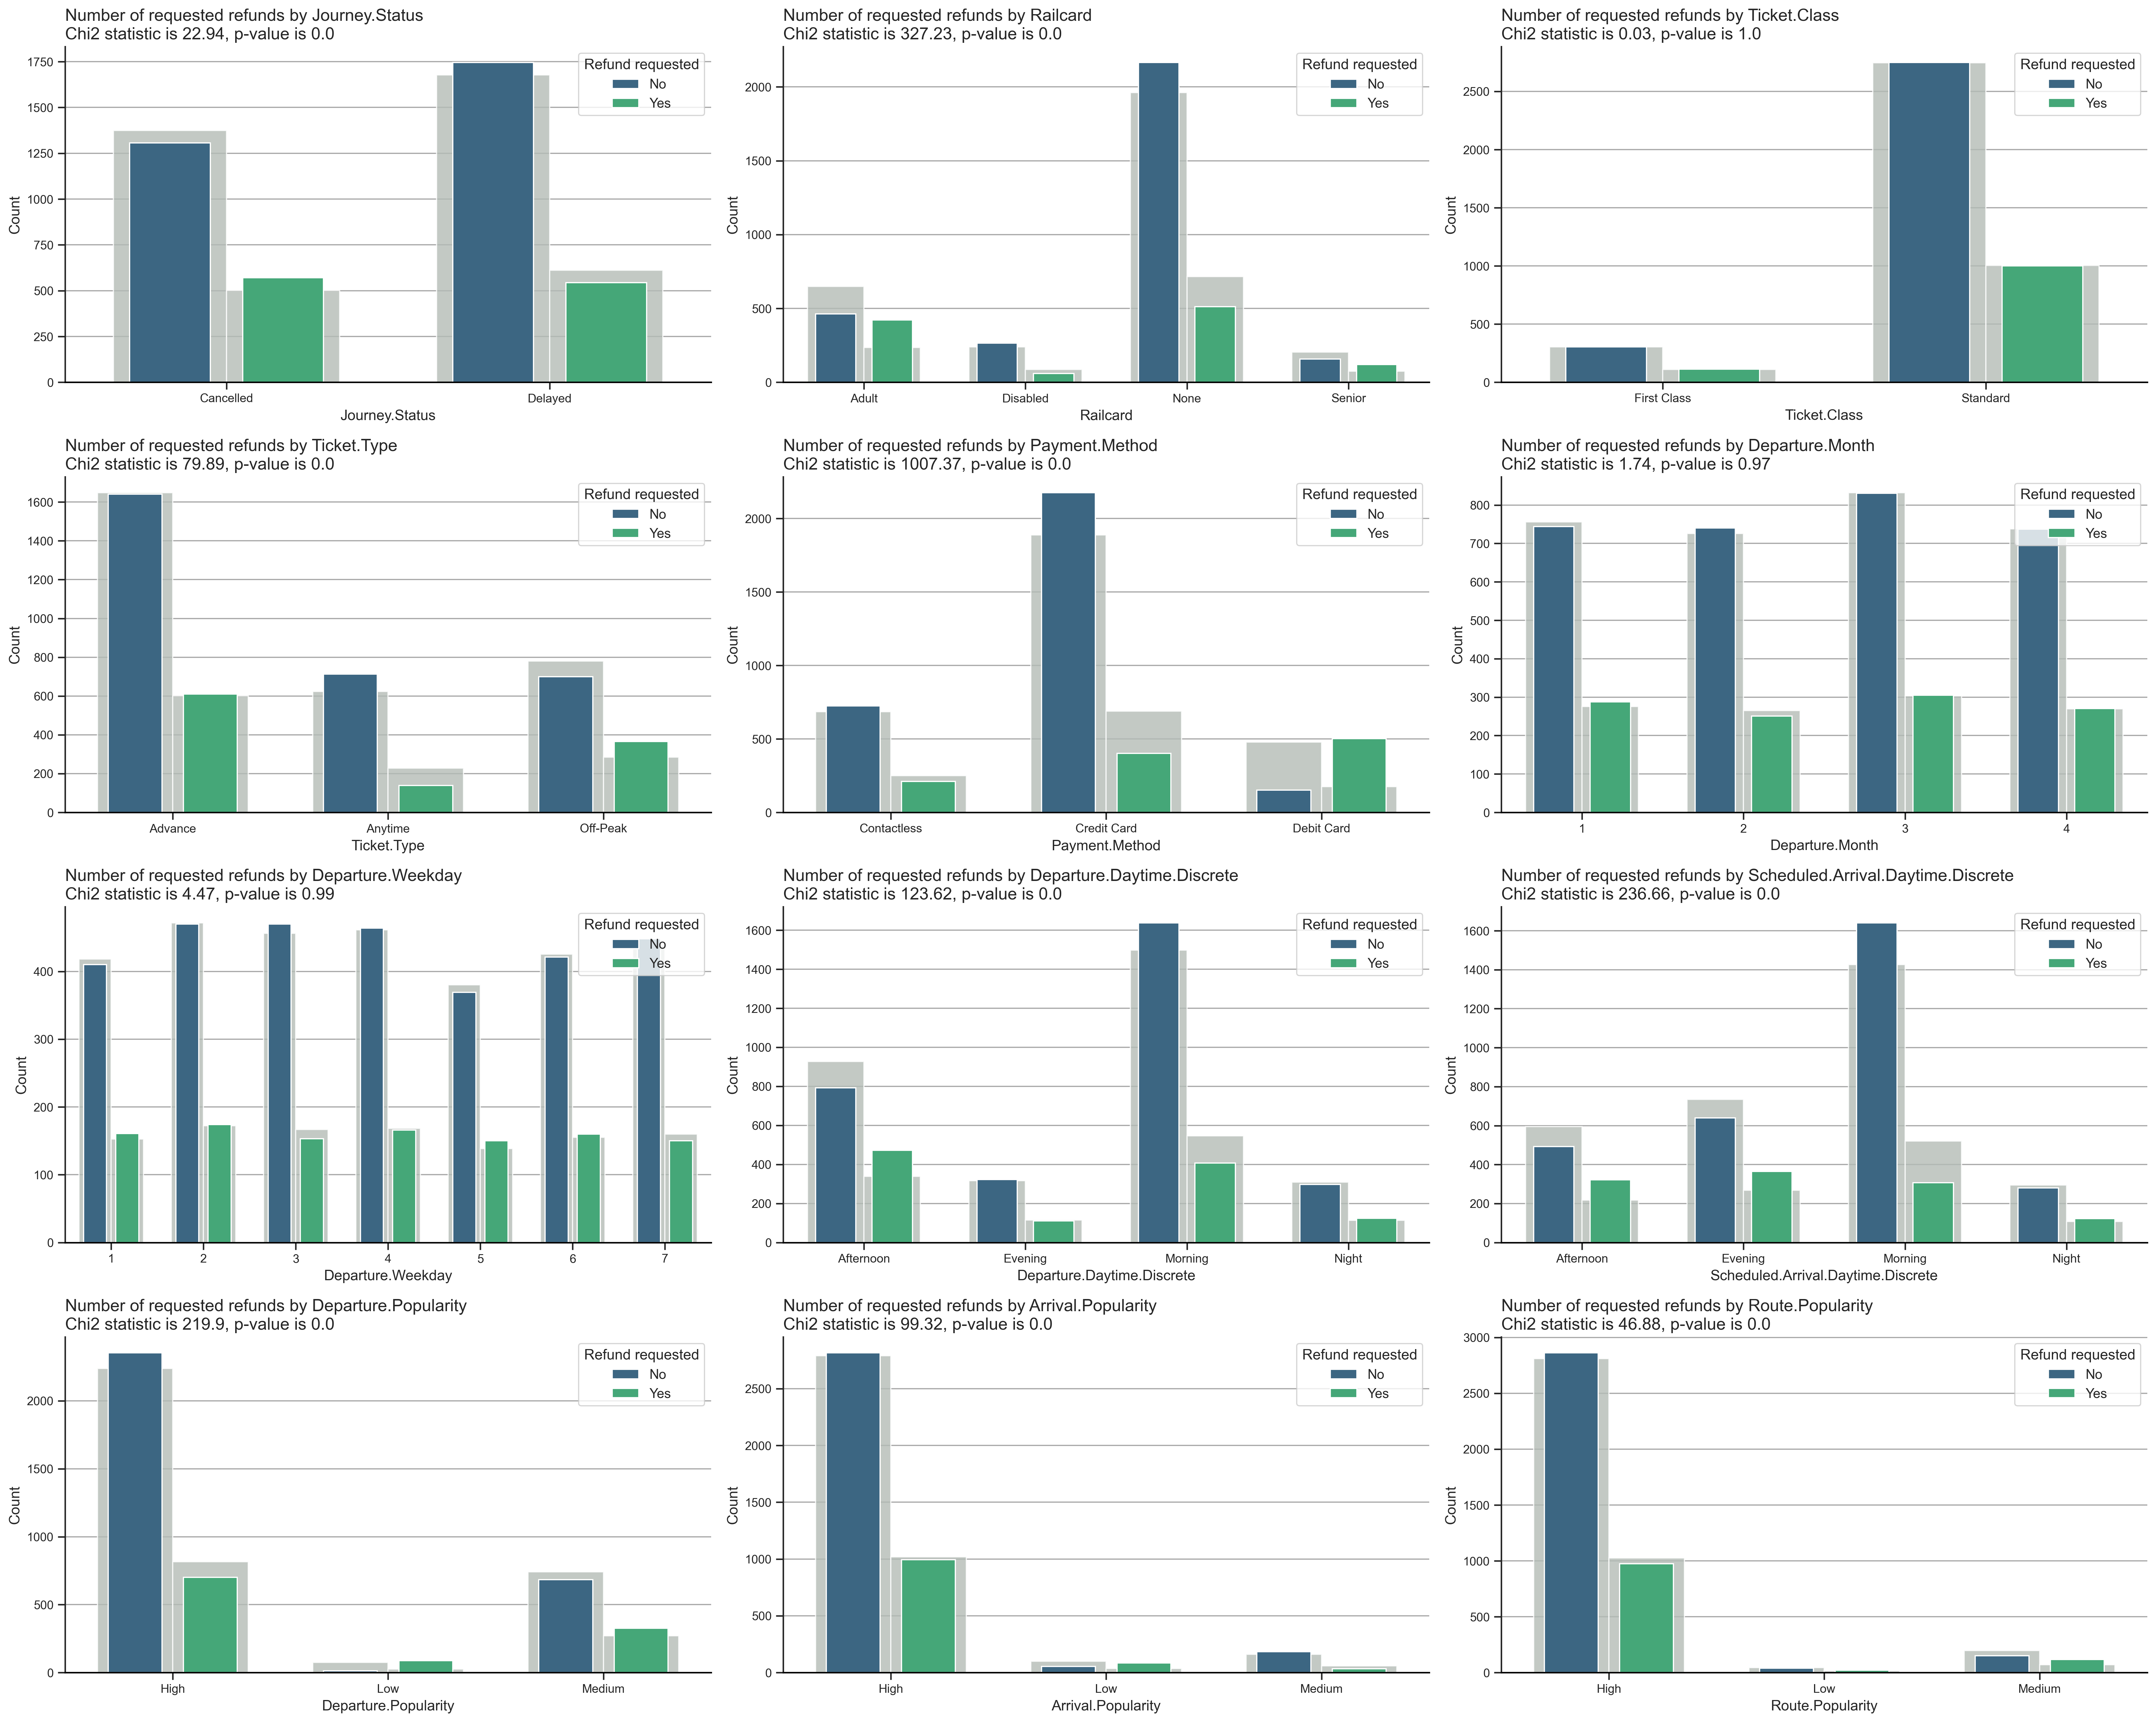

In [814]:
#slotting frequencies of refund requests in relation to other categorical variables that are present in the dataset  

num_cols = 3
keys = [key for key in crosstab_dict.keys() if key not in ['Departure.Station', 'Arrival.Station']]
num_figures = len(keys)
num_rows = int(np.ceil(num_figures / num_cols))

fig_dict = {}

plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(num_rows, num_cols, figsize = (25, 20))
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style = 'white', rc = custom_params)

width0 = 0.7
width1 = 0.5
response_val = list(trips_df['Refund.Request'].unique())

fig_num = 0
for key in keys:

    row = fig_num // num_cols
    col = fig_num % num_cols
    
    data_o = pd.melt(pd.DataFrame(crosstab_dict[key]['observed'],
                                  index = crosstab_dict[key]['o_titles'],
                                  columns = response_val),
                     value_vars = response_val,
                     var_name = 'Refund.Request',
                     value_name = 'Count',
                     ignore_index = False).reset_index(drop = False)
    
    data_e = pd.melt(pd.DataFrame(crosstab_dict[key]['expected'],
                                  index = crosstab_dict[key]['e_titles'],
                                  columns = response_val),
                     value_vars = response_val,
                     var_name = 'Refund.Request',
                     value_name = 'Count',
                     ignore_index = False).reset_index(drop = False)
    
    
    fig0 = sns.barplot(data_e, x = key, y = 'Count', hue = 'Refund.Request',
                       palette = ['#B2BEB5'] * 20, alpha = 0.8, width = width0, ax = ax[row, col])
    fig1 = sns.barplot(data_o, x = key, y = 'Count', hue = 'Refund.Request',
                       palette = 'viridis', alpha = 1, width = width1,  ax = ax[row, col])
    
    group_num = int(len(fig0.containers)/2)
    
    for i in range(group_num, len(fig0.containers)):
        for j in range(len(fig0.containers[i])):
            start = fig0.containers[i - group_num][j].get_x()
            width = fig0.containers[i - group_num][j].get_width()
            fig0.containers[i][j].set_x(start + ((1 - width1/width0)*width)/2)
    
    handles, labels = ax[row, col].get_legend_handles_labels()
    ax[row, col].legend(handles[2:], labels[2:], title = 'Refund requested')
    ax[row, col].set_title('Number of requested refunds by {0}\nChi2 statistic is {1}, p-value is {2}'.format(key,
                            round(crosstab_dict[key]['chi2'].statistic, 2),
                            round(crosstab_dict[key]['chi2'].pvalue, 2)), fontsize = 14, loc = 'left')
    ax[row, col].tick_params(labelsize = 10)
    ax[row, col].spines['top'].set_visible(False)
    ax[row, col].spines['right'].set_visible(False)
    ax[row, col].spines['bottom'].set_color('#000000')
    ax[row, col].tick_params(bottom = True, left = True)
    ax[row, col].set_axisbelow(True)
    ax[row, col].yaxis.grid(True, color = '#A9A9A9')
    ax[row, col].xaxis.grid(False)

    fig_num += 1

fig.tight_layout()
fig.show()
fig.savefig('Figures/categorical_response.png', format = 'png', dpi = 300)

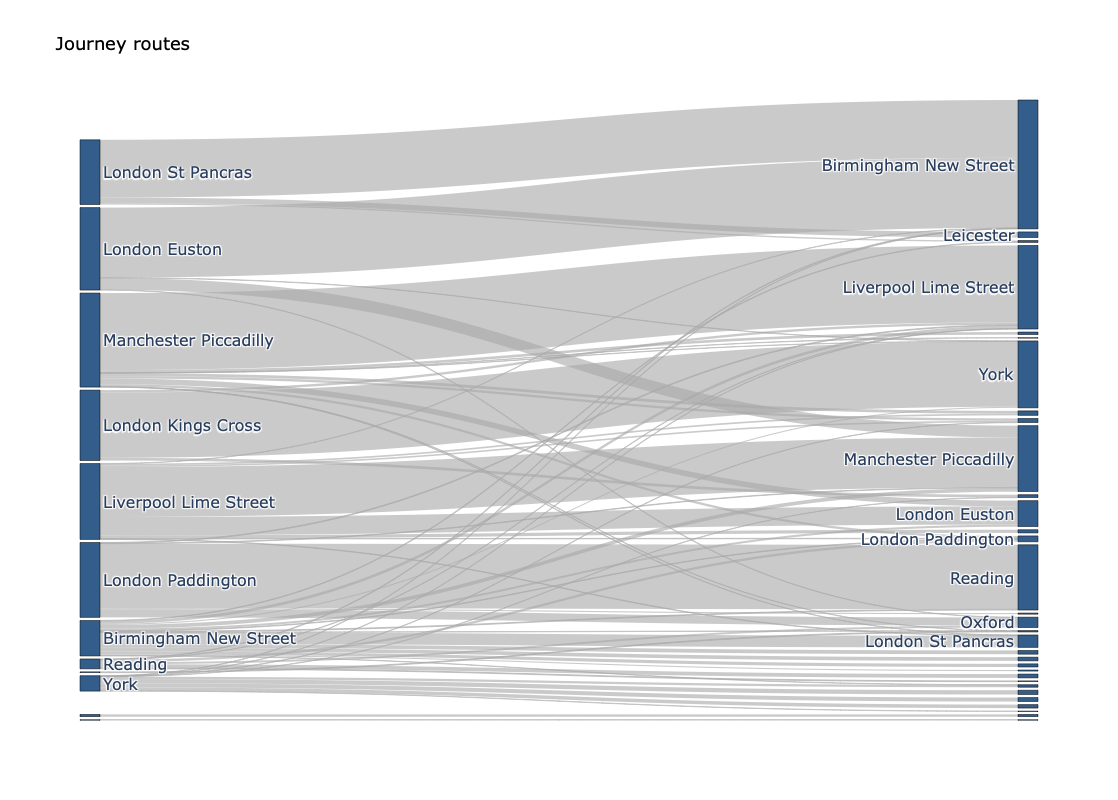

In [2204]:
#sunkey diagram plotting for illusrating number of journeys by routes

threshold = 300

destinations = pd.concat([trips_df['Departure.Station'].value_counts(), trips_df['Arrival.Station'].value_counts()], axis = 0)
n_dep = len(list(trips_df['Departure.Station'].unique()))
departures = {name : i for i , name in enumerate(list(destinations.index[0:n_dep]))}
arrivals = {name : i for i , name in enumerate(list(destinations.index[n_dep:]), start = len(departures))}
sankey_df = trips_df.assign(source = trips_df['Departure.Station'].map(departures), target = trips_df['Arrival.Station'].map(arrivals)). \
                            groupby(['source', 'target'], as_index = False)['Departure'].count().rename(columns = {'Departure' : 'value'})
  
fig = go.Figure(data=[go.Sankey(node = dict(
                          pad = 3,
                          thickness = 20,
                          line = dict(color = 'black', width = 0.5),
                          label = [label if size >= threshold else '' for label, size in zip(list(destinations.index), destinations.tolist())],
                          customdata = list(destinations.index),
                          hovertemplate = '%{customdata}',
                          color = 'rgba(0.2,0.37,0.55,1.0)'),
                        link = dict(
                            source = sankey_df['source'].tolist(),
                            target = sankey_df['target'].tolist(),
                            value = sankey_df['value'].tolist(),
                            color = 'rgba(169,169,169,0.6)'))])

fig.update_layout(
    width = 800, height = 800,
    paper_bgcolor = 'rgba(0,0,0,0)', plot_bgcolor = 'rgba(0,0,0,0)',
    title_text = 'Journey routes', title_font = dict(size = 18, color = 'black'), font_size = 16)
fig.write_image('Figures/sankey_routes.png', scale = 2.2)
fig.show()

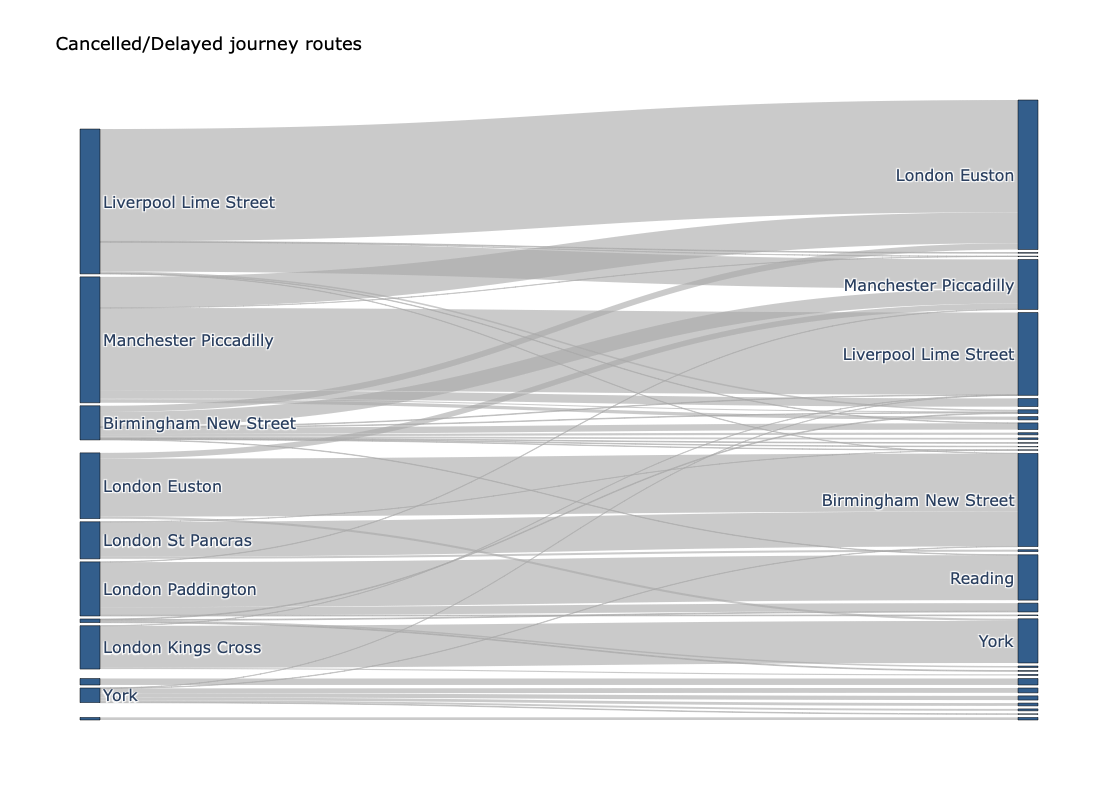

In [2206]:
#sunkey diagram plotting for illusrating number of journeys by routes - restricted to delayed or cancelled journeys

threshold = 100

trips_refund_eligible = trips_df[trips_df['Journey.Status'] != 'On Time'].reset_index(drop = True)
destinations = pd.concat([trips_refund_eligible['Departure.Station'].value_counts(),
                          trips_refund_eligible['Arrival.Station'].value_counts()], axis = 0)
n_dep = len(list(trips_refund_eligible['Departure.Station'].unique()))
departures = {name : i for i , name in enumerate(list(destinations.index[0:n_dep]))}
arrivals = {name : i for i , name in enumerate(list(destinations.index[n_dep:]), start = len(departures))}
sankey_df = trips_refund_eligible.assign(source = trips_refund_eligible['Departure.Station'].map(departures),
                                         target = trips_refund_eligible['Arrival.Station'].map(arrivals)). \
                            groupby(['source', 'target'], as_index = False)['Departure'].count().rename(columns = {'Departure' : 'value'})
  
fig = go.Figure(data=[go.Sankey(node = dict(
                          pad = 3,
                          thickness = 20,
                          line = dict(color = 'black', width = 0.5),
                          label = [label if size >= threshold else '' for label, size in zip(list(destinations.index), destinations.tolist())],
                          customdata = list(destinations.index),
                          hovertemplate = '%{customdata}',
                          color = 'rgba(0.2,0.37,0.55,1.0)'),
                        link = dict(
                            source = sankey_df['source'].tolist(),
                            target = sankey_df['target'].tolist(),
                            value = sankey_df['value'].tolist(),
                            color = 'rgba(169,169,169,0.6)'))])

fig.update_layout(
    width = 800, height = 800,
    paper_bgcolor = 'rgba(0,0,0,0)', plot_bgcolor = 'rgba(0,0,0,0)',
    title_text = 'Cancelled/Delayed journey routes', title_font = dict(size = 18, color = 'black'), font_size = 16)
fig.write_image('Figures/sankey_routes_dc.png', scale = 2.2)
fig.show()

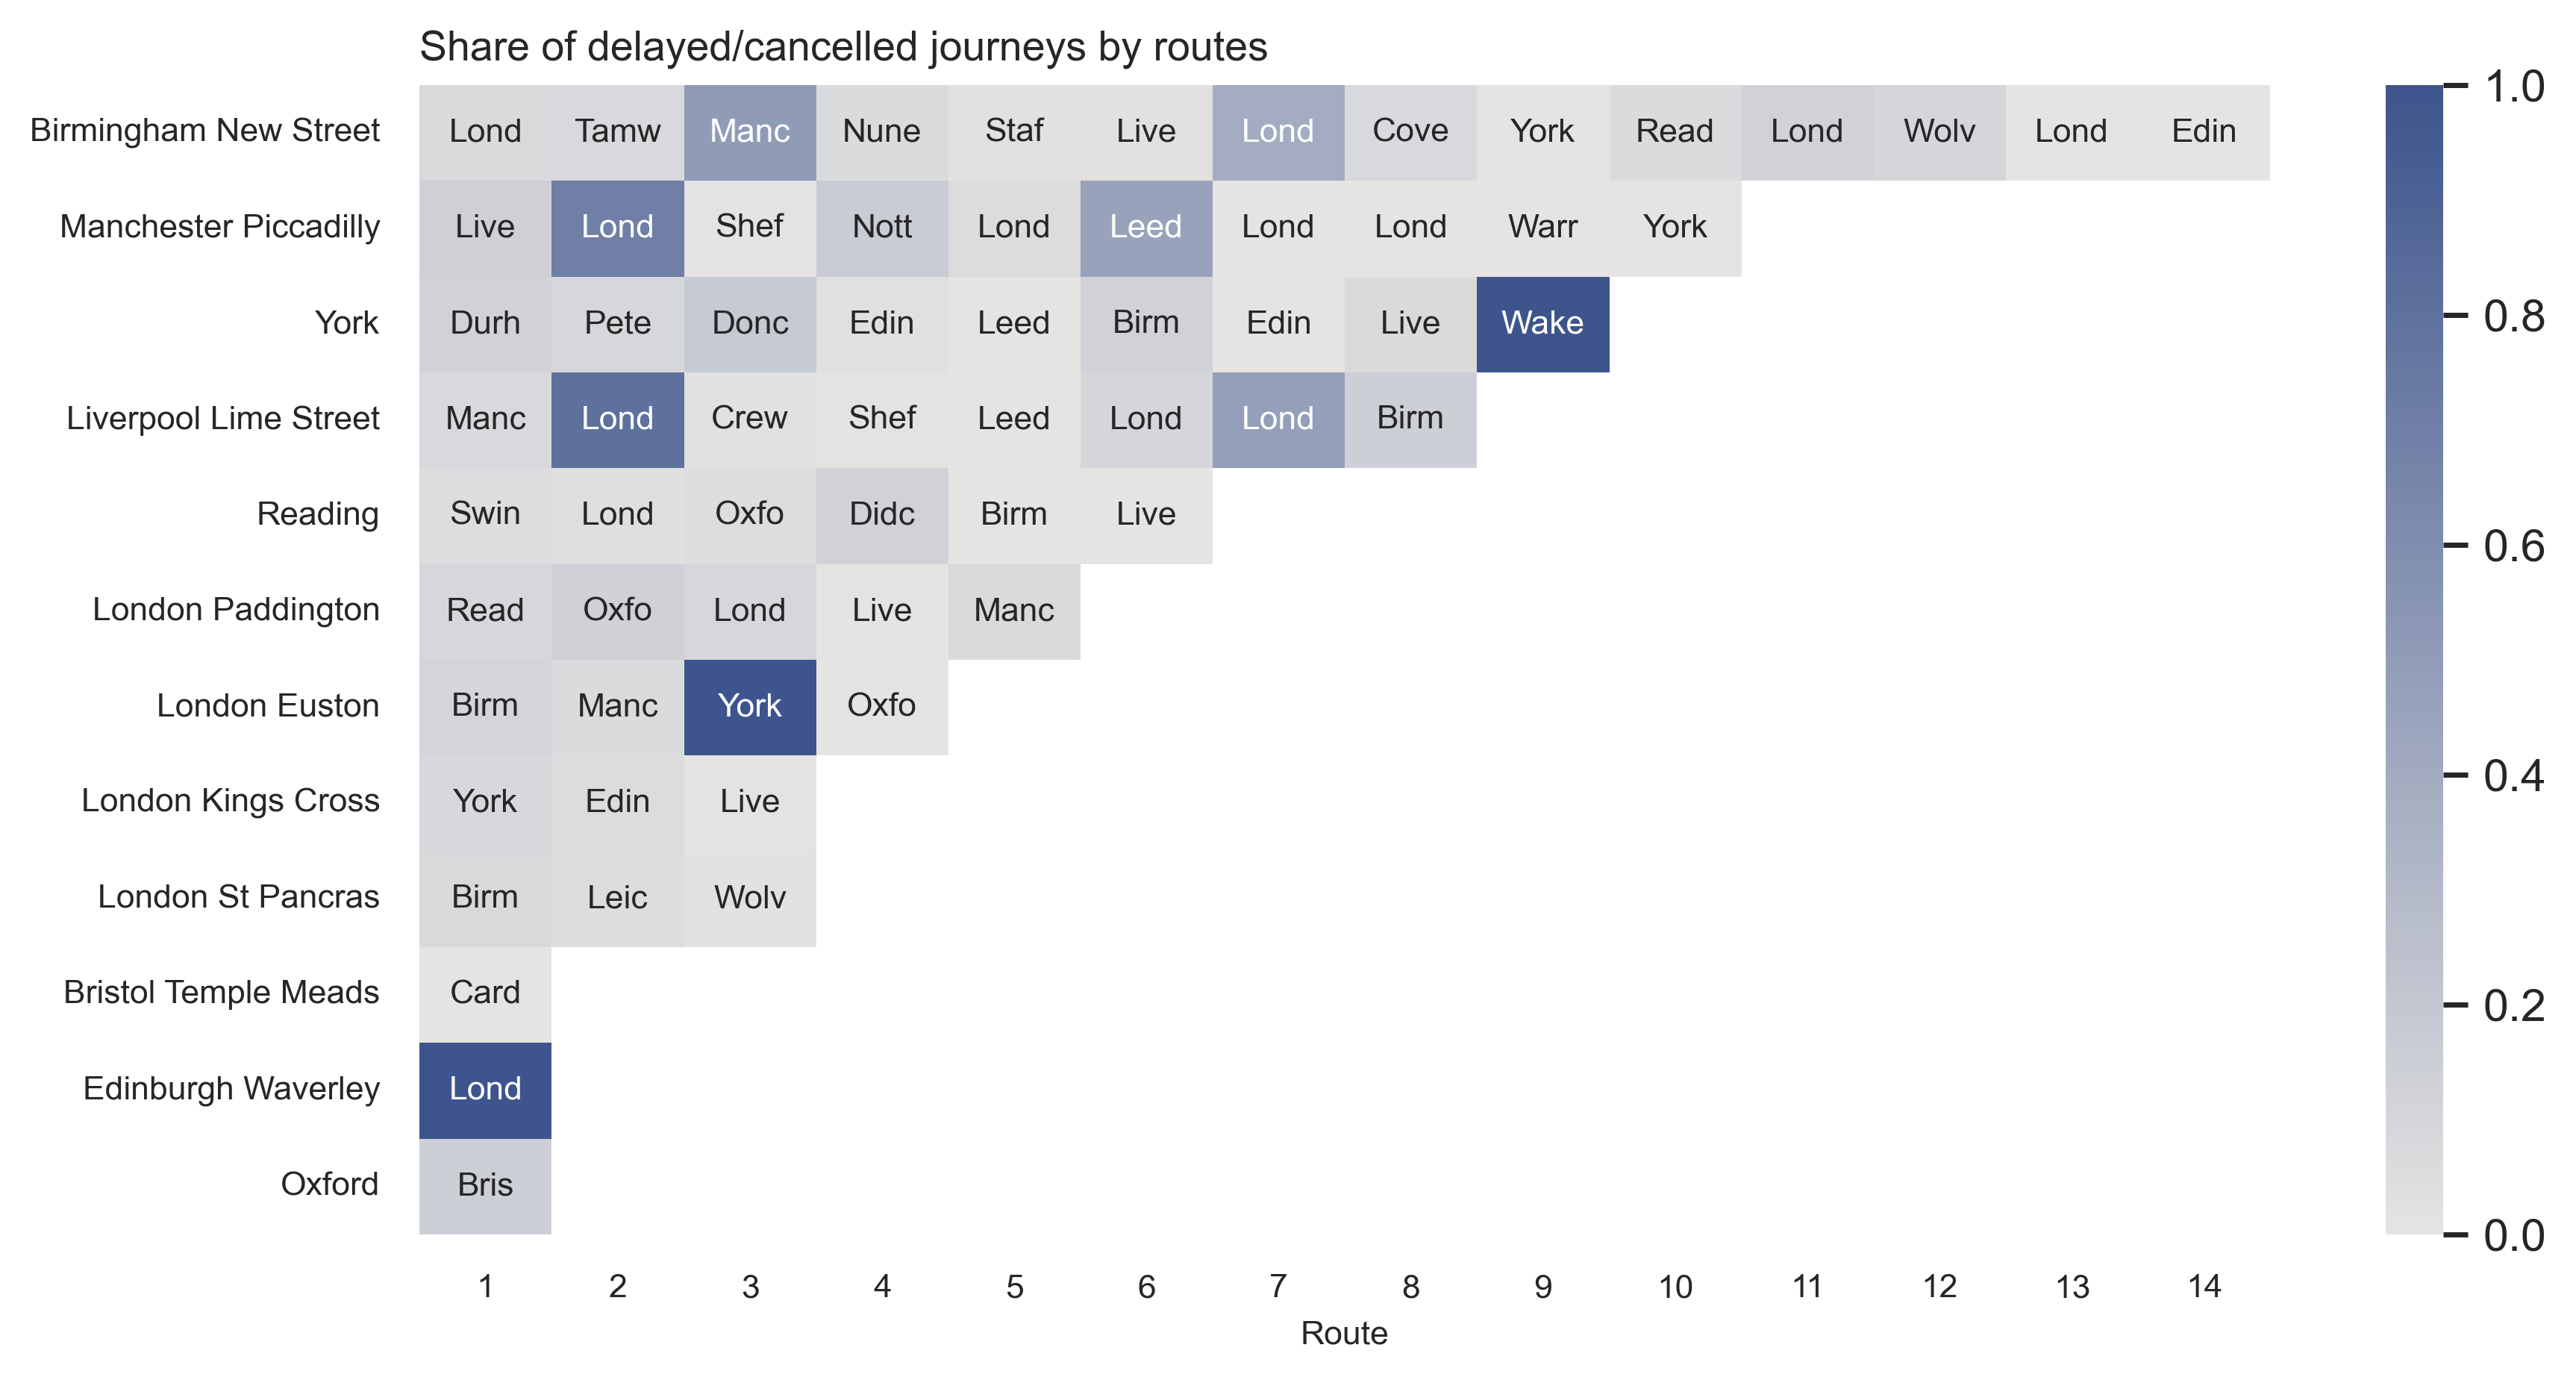

In [817]:
#visualization of journey delay/cancellation rates distributed by specific routes

heat_map_df = trips_df.assign(yes = trips_df['Journey.Status'] != 'On Time',
                no = trips_df['Journey.Status'] == 'On Time').groupby(['Departure.Station', 'Arrival.Station'],
                                                             as_index = False)[['yes', 'no']].sum()
heat_map_df['share'] = heat_map_df['yes']/(heat_map_df['yes'] + heat_map_df['no'])
heat_map_df['Arrival.Station'] = heat_map_df['Arrival.Station'].str[0:4]

heat_map_df = heat_map_df.sort_values(by = ['yes', 'no'],
                    key = lambda x: heat_map_df['yes'] + heat_map_df['no'],
                        ascending = False).reset_index(drop = True)

heat_map_df['rank'] = heat_map_df.groupby(['Departure.Station']).cumcount() + 1

heat_map_mat = heat_map_df.pivot(index = 'Departure.Station', columns = 'rank', values = 'share')

heat_map_mat = heat_map_mat.sort_values(by = list(heat_map_mat.columns),
                        key = lambda x: heat_map_mat.notna().sum(axis = 1), ascending = False)

heat_map_annot = heat_map_df.pivot(index = 'Departure.Station', columns = 'rank', values = 'Arrival.Station')

heat_map_annot = heat_map_annot.sort_values(by = list(heat_map_annot.columns),
                        key = lambda x: heat_map_annot.notna().sum(axis = 1), ascending = False).fillna('')

norm = mtcol.Normalize(0, 1)
colors = [[norm(0), '#E5E4E2'],
          [norm(1), '#3B528B']]

cmap = mtcol.LinearSegmentedColormap.from_list('', colors)
plt.rcParams['figure.dpi'] = 400
fig, ax = plt.subplots(1, figsize = (10, 5))

sns.heatmap(heat_map_mat, cmap = cmap,
            annot = heat_map_annot, alpha = 0.99, fmt = '', annot_kws = {'size' : 8}, ax = ax)
ax.set_title('Share of delayed/cancelled journeys by routes', fontsize = 10, loc = 'left')
ax.set_xlabel('Route', fontsize = 8)
ax.set_ylabel('', fontsize = 0)
ax.tick_params(labelsize = 8)

fig.savefig('Figures/journey_heat_map.png', format = 'png', dpi = 400)

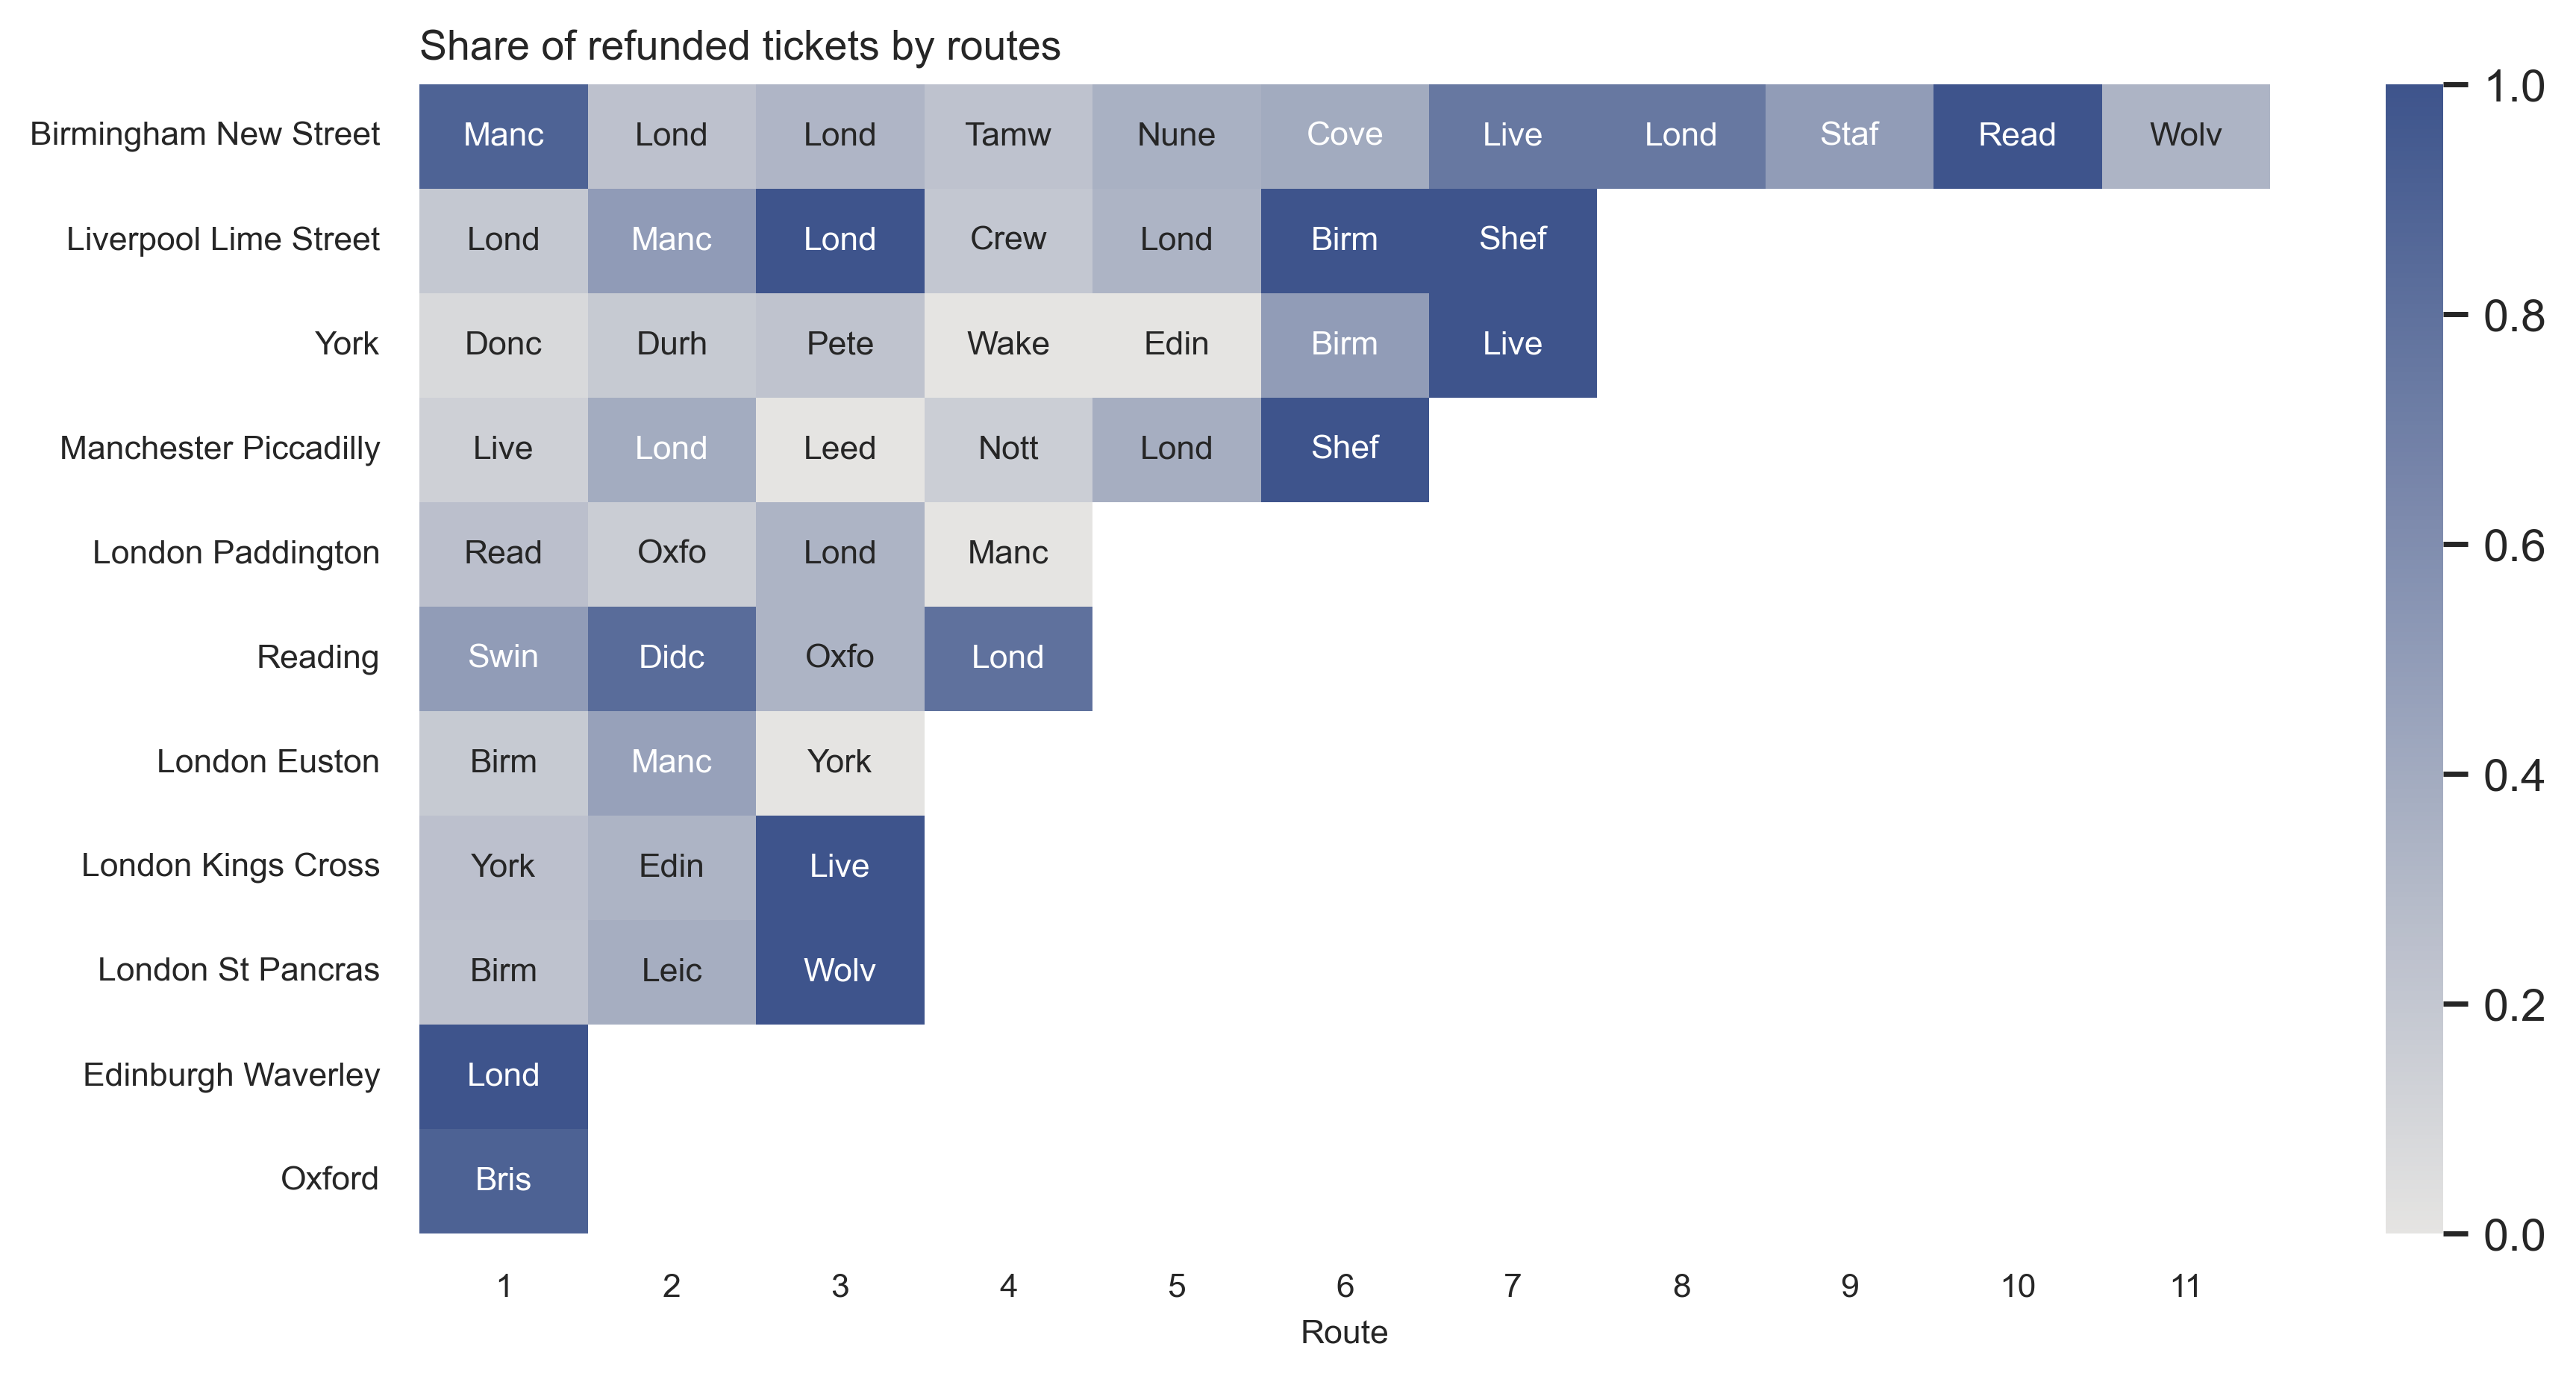

In [882]:
#visualization of ticket refund requests rates distributed by specific routes

heat_map_df = trips_refund_eligible.assign(yes = trips_refund_eligible['Refund.Request'] == 'Yes',
                no = trips_refund_eligible['Refund.Request'] == 'No').groupby(['Departure.Station', 'Arrival.Station'],
                                                             as_index = False)[['yes', 'no']].sum()
heat_map_df['share'] = heat_map_df['yes']/(heat_map_df['yes'] + heat_map_df['no'])
heat_map_df['Arrival.Station'] = heat_map_df['Arrival.Station'].str[0:4]

heat_map_df = heat_map_df.sort_values(by = ['yes', 'no'],
                    key = lambda x: heat_map_df['yes'] + heat_map_df['no'],
                        ascending = False).reset_index(drop = True)

heat_map_df['rank'] = heat_map_df.groupby(['Departure.Station']).cumcount() + 1

heat_map_mat = heat_map_df.pivot(index = 'Departure.Station', columns = 'rank', values = 'share')

heat_map_mat = heat_map_mat.sort_values(by = list(heat_map_mat.columns),
                        key = lambda x: heat_map_mat.notna().sum(axis = 1), ascending = False)

heat_map_annot = heat_map_df.pivot(index = 'Departure.Station', columns = 'rank', values = 'Arrival.Station')

heat_map_annot = heat_map_annot.sort_values(by = list(heat_map_annot.columns),
                        key = lambda x: heat_map_annot.notna().sum(axis = 1), ascending = False).fillna('')

norm = mtcol.Normalize(0, 1)
colors = [[norm(0), '#E5E4E2'],
          [norm(1), '#3B528B']]

cmap = mtcol.LinearSegmentedColormap.from_list('', colors)
plt.rcParams['figure.dpi'] = 400
fig, ax = plt.subplots(1, figsize = (10, 5))

sns.heatmap(heat_map_mat, cmap = cmap,
            annot = heat_map_annot, alpha = 0.99, fmt = '', annot_kws = {'size' : 8}, ax = ax)
ax.set_title('Share of refunded tickets by routes', fontsize = 10, loc = 'left')
ax.set_xlabel('Route', fontsize = 8)
ax.set_ylabel('', fontsize = 0)
ax.tick_params(labelsize = 8)

fig.savefig('Figures/journey_heat_map_dc.png', format = 'png', dpi = 400)

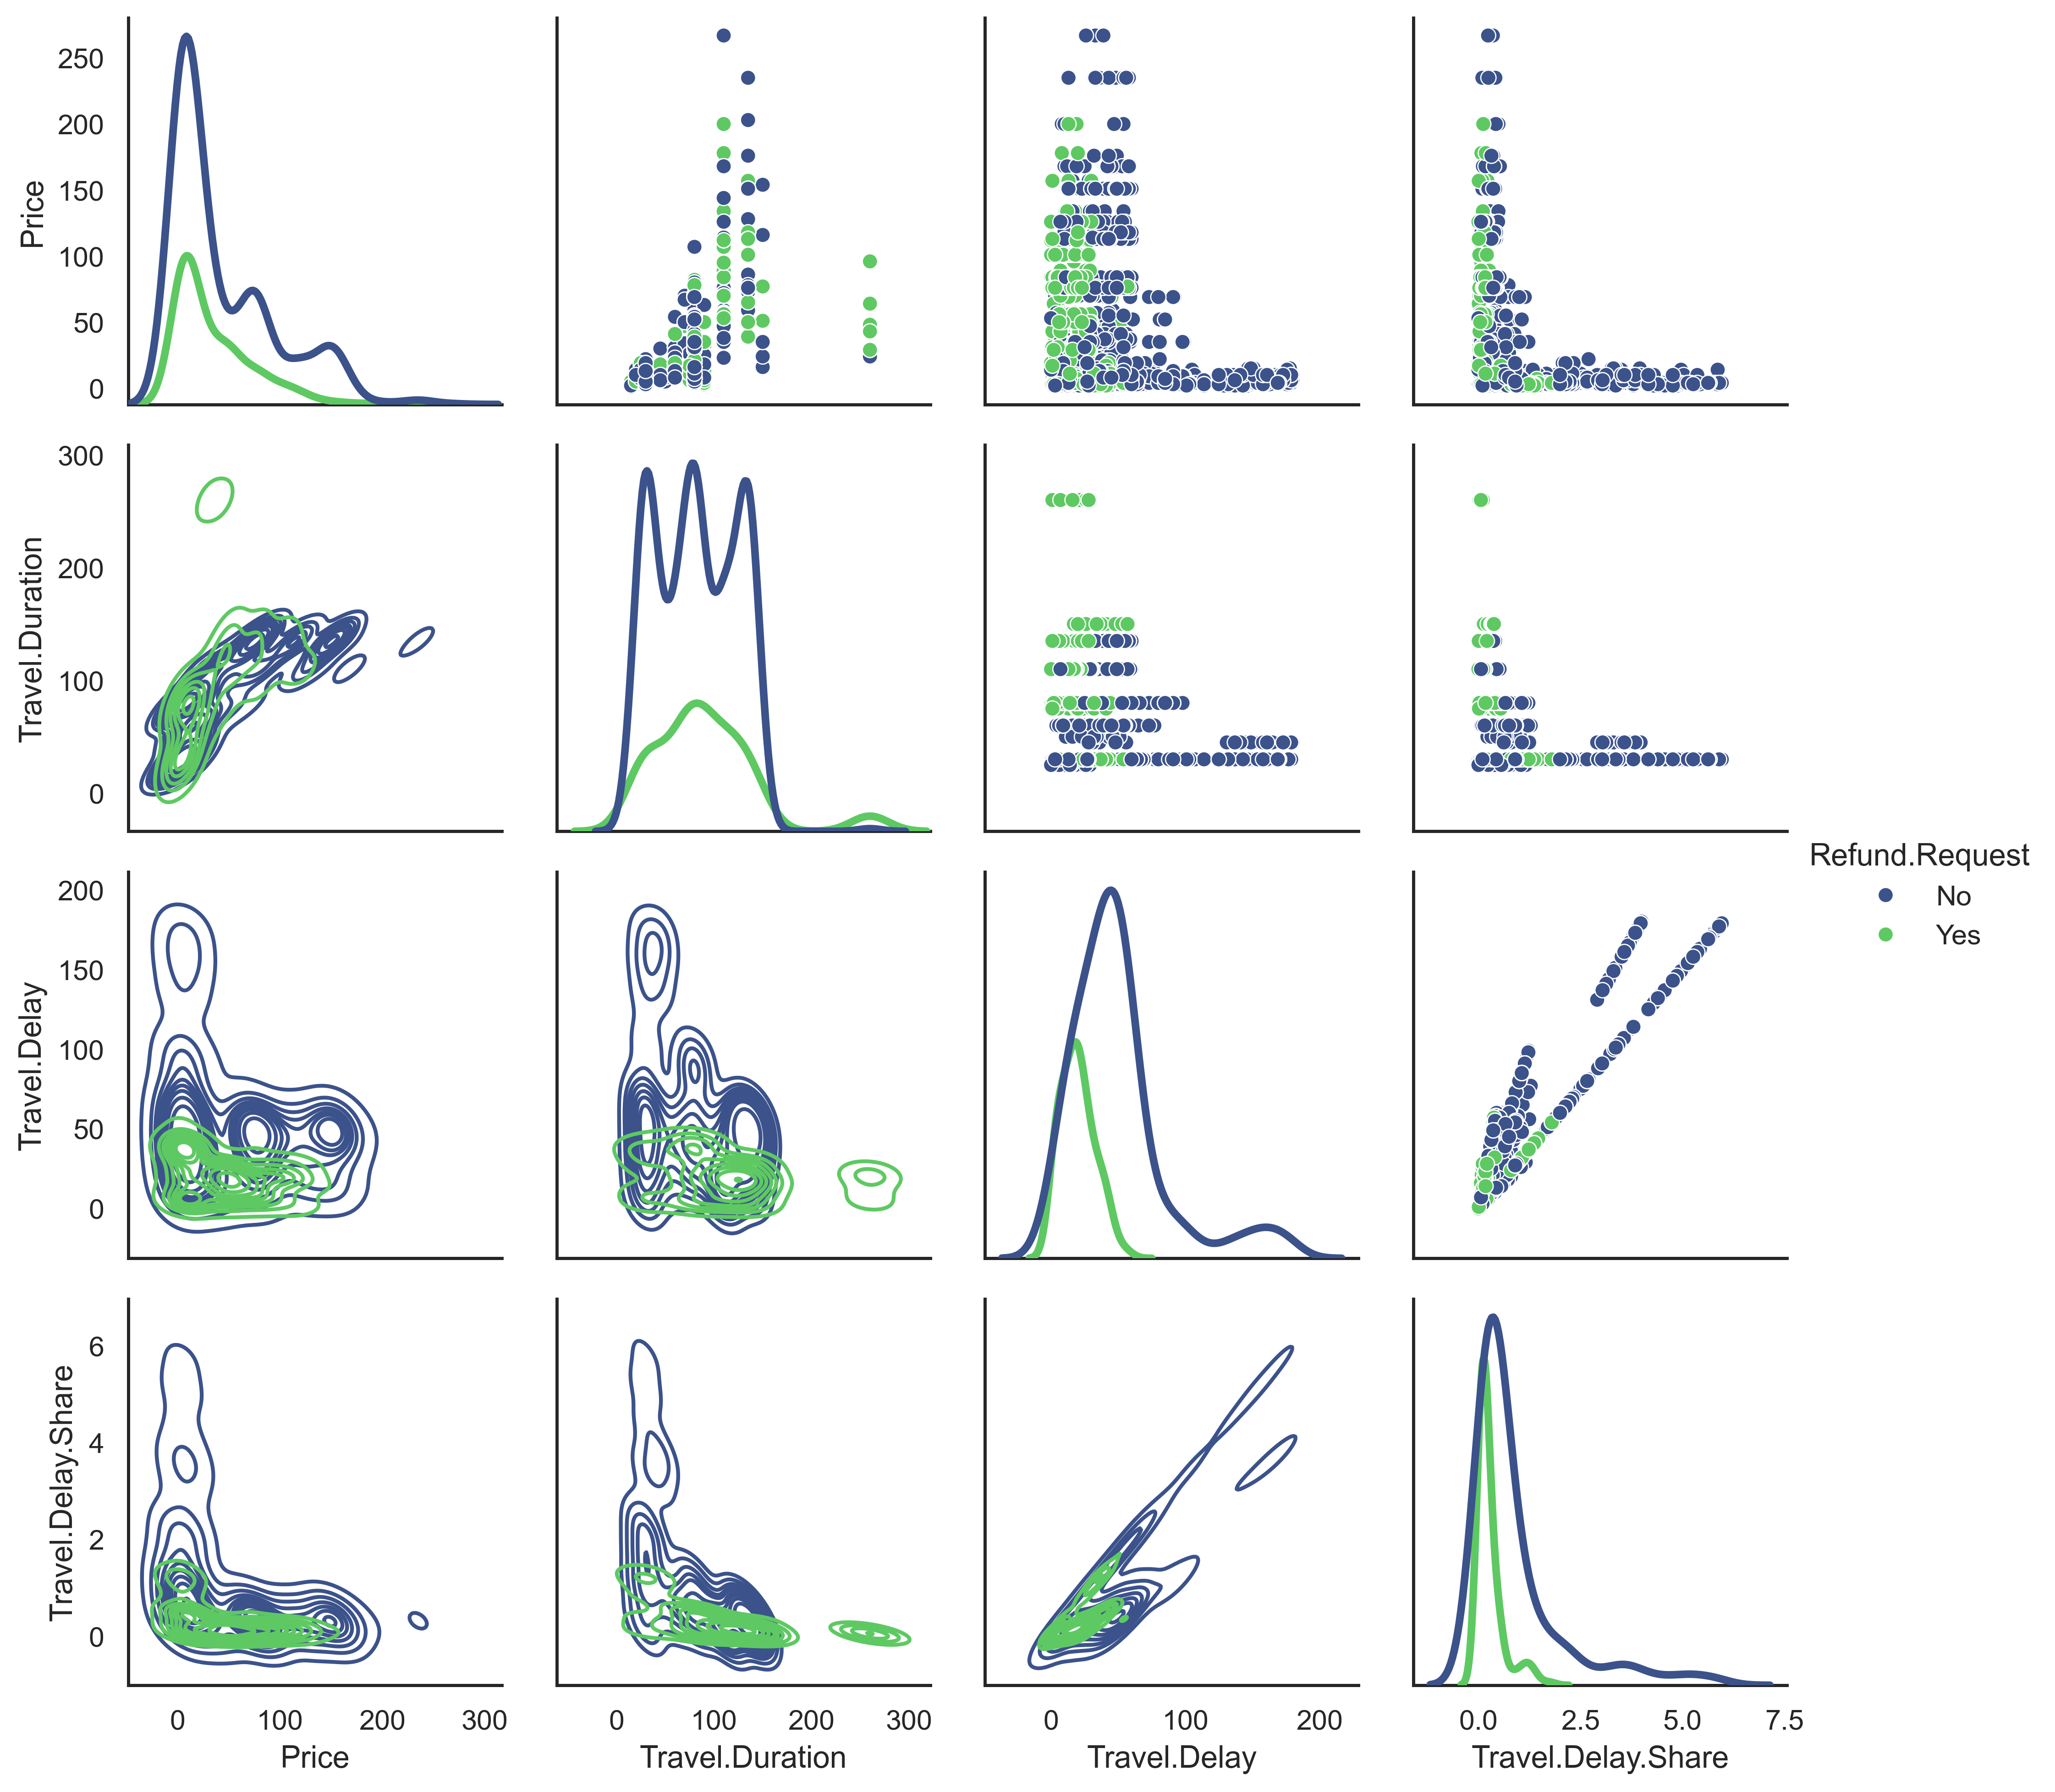

In [825]:
#pairplo that illustrates pairwise relationship between all continuous variables featured in the dataset

continuous_cols = trips_df.select_dtypes(include = ['int64', 'float64']).columns[0:4]

pair_plot = sns.PairGrid(trips_refund_eligible, diag_sharey = False, hue = 'Refund.Request',
                         palette = ['#3B528B', '#5EC962'], vars = list(continuous_cols))
pair_plot.map_lower(sns.kdeplot, fill = False)
pair_plot.map_upper(sns.scatterplot)
pair_plot.map_diag(sns.kdeplot, lw = 3, bw_adjust = 1.5)
pair_plot.add_legend()

pair_plot.savefig('Figures/continuous_pair_plot.pdf')

In [826]:
#check of price variability within Railcard, Ticket.Class, Ticket.Type and Route groups to identify precense 
#of potential unobserved factors influencing the price 

print('The mean root sum of squares of price deviation equals', 
      str(round(np.sqrt((trips_df['Price.Deviation']**2).sum()/trips_df.shape[0]), 3)) + ',',
     'indicating that the price of a journey is a linear function of four feautures - Railcard, Ticket.Class, Ticket.Type and Route.')

The mean root sum of squares of price deviation equals 0.056, indicating that the price of a journey is a linear function of four feautures - Railcard, Ticket.Class, Ticket.Type and Route.


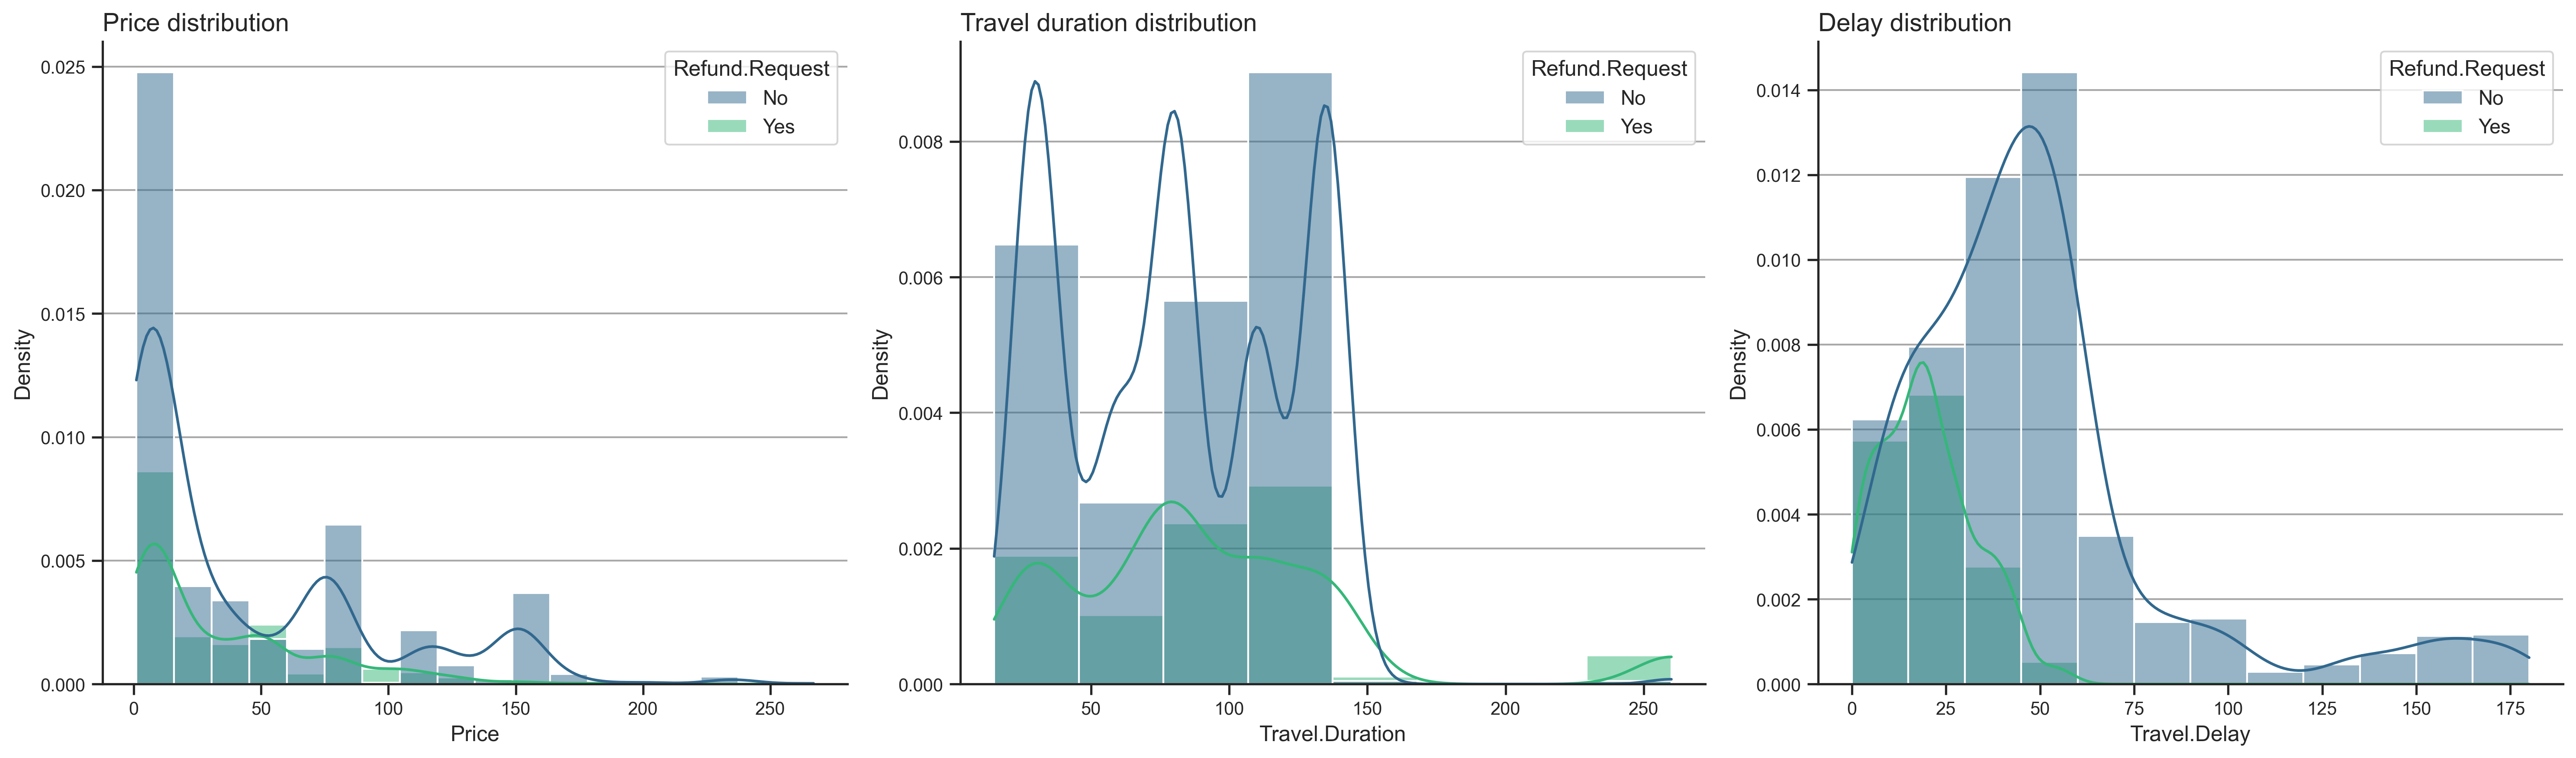

In [827]:
#plotting histrogram-based and kde-based distribution estimated, broken down Refund.Requested attribute 

plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, 3, figsize = (20, 6))
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style = 'white', rc = custom_params)

sns.histplot(data = trips_refund_eligible, x = 'Price', hue = 'Refund.Request', kde=True, stat = 'density',
             binwidth = 15, palette = 'viridis', ax = ax[0])
sns.histplot(data = trips_refund_eligible, x = 'Travel.Duration', hue = 'Refund.Request', kde=True, stat = 'density',
             binwidth = 30, palette = 'viridis', ax = ax[1])
sns.histplot(data = trips_refund_eligible, x = 'Travel.Delay', hue = 'Refund.Request', kde=True, stat = 'density',
             binwidth = 15, palette = 'viridis', ax = ax[2])


ax[0].set_title('Price distribution', fontsize = 14, loc = 'left')
ax[1].set_title('Travel duration distribution', fontsize = 14, loc = 'left')
ax[2].set_title('Delay distribution', fontsize = 14, loc = 'left')
ax[0].tick_params(labelsize = 10)
ax[0].tick_params(bottom = True, left = True)
ax[0].yaxis.grid(True, color = '#A9A9A9')
ax[0].xaxis.grid(False)
ax[1].tick_params(labelsize = 10)
ax[1].tick_params(bottom = True, left = True)
ax[1].yaxis.grid(True, color = '#A9A9A9')
ax[1].xaxis.grid(False)
ax[2].tick_params(labelsize = 10)
ax[2].tick_params(bottom = True, left = True)
ax[2].yaxis.grid(True, color = '#A9A9A9')
ax[2].xaxis.grid(False)

fig.tight_layout()
fig.show()
fig.savefig('Figures/continuous_distribution.png', format = 'png', dpi = 300)

## Univariate regression analysis

In [2224]:
#Feature creation and renaming
trips_refund_eligible.rename(columns = {'Travel.Delay' : 'DelayInMinutes'}, inplace = True)
trips_refund_eligible['MediumPrice'] = trips_refund_eligible['Price'].between(10, 30, inclusive = 'right') #medium price binary variable

In [838]:
#Univariate linear model fit using GLM with a Binomial family of distributions
response_var = np.where(trips_refund_eligible['Refund.Request'] == 'Yes', 1, 0)
expl_var = trips_refund_eligible[['MediumPrice']]
expl_var = sm.add_constant(expl_var)
glm_bernoulli_u = sm.GLM(response_var, expl_var.astype('int8'), family = sm.families.Binomial())
glm_bernoulli_u = glm_bernoulli_u.fit()

glm_bernoulli_u.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 4166
Model:                            GLM   Df Residuals:                     4164
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2411.0
Date:                Wed, 20 Nov 2024   Deviance:                       4822.0
Time:                        00:55:38   Pearson chi2:                 4.17e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.003852
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.0757      0.039    -27.383      0.000      -1.153      -0.999
MediumPrice     0.3544      0.087      4.063      0.000       0.183       0.525
===============================================================================
"""

In [840]:
#function that predicts resulting probabilities based on univariate regression coefficient estimates
def predict_probability_univariate(model, x_val):
    log_odds = model.params[0] + model.params[1] * x_val
    return np.exp(log_odds) / (1 + np.exp(log_odds))

In [842]:
#prediction of probabilities for cases outlined in the coursework task description
p1 = 5
p2 = 25

print('Probability of a refund if a ticket was purchased for a price of {0} pounds: {1}' \
          .format(p1, round(predict_probability_univariate(glm_bernoulli_u, (10 < p1 <= 30)), 3)),
      'Probability of a refund if a ticket was purchased for a price of {0} pounds: {1}' \
          .format(p2, round(predict_probability_univariate(glm_bernoulli_u, (10 < p2 <= 30)), 3)), sep = '\n')

Probability of a refund if a ticket was purchased for a price of 5 pounds: 0.254
Probability of a refund if a ticket was purchased for a price of 25 pounds: 0.327


## Multivariate regression analysis

In [2226]:
#creation of dummy variable for categorical regressors
dummy_columns = ['Journey.Status', 'Payment.Method', 'Railcard', 'Ticket.Class', 'Ticket.Type',
                 'Departure.Daytime.Discrete', 'Scheduled.Arrival.Daytime.Discrete',
                 'Departure.Popularity', 'Arrival.Popularity', 'Route.Popularity']

dummy_prefix = ['Journey.Status', 'Payment.Method', 'Railcard', 'Ticket.Class', 'Ticket.Type',
                 'Departure.Daytime', 'Scheduled.Arrival.Daytime',
                 'Departure.Popularity', 'Arrival.Popularity', 'Route.Popularity']

baseline_vals = ['Delayed', 'Contactless', 'None', 'Standard', 'Advance',
                 'Night', 'Night', 'High', 'High', 'High']

dummy_df = pd.get_dummies(trips_refund_eligible, prefix = dummy_prefix, prefix_sep = '_',
                          columns = dummy_columns, sparse = False, drop_first = False, dtype = 'int8')

dummy_names = dummy_df.columns[[col.startswith(tuple([col + '_' for col in dummy_prefix])) for col in dummy_df.columns]]
dummy_df = dummy_df[dummy_names]
dummy_df.drop(columns = [pref + '_' + val for pref, val in zip(dummy_prefix, baseline_vals)], inplace = True)

In [2228]:
#creating continuous features polynomials and interactions
polynom = PolynomialFeatures(degree = 2, interaction_only = False, include_bias = False)
polynom_df = pd.DataFrame(polynom.fit_transform(trips_refund_eligible[['Price', 'Travel.Duration', 'DelayInMinutes']].fillna(0)),
                          columns = [name.replace(' ', '_x_')for name in polynom.get_feature_names_out()])
polynom_df = polynom_df[sorted(list(polynom_df.columns))]

#function for modeling selected dummy variable interactions with the rest
def var_df_interaction(series, interaction_cols, source_df):
    return pd.DataFrame(numpy.expand_dims(source_df[series].values, axis = 1) * source_df[interaction_cols].values,
                            columns = [series + '_x_' + col for col in interaction_cols])

interaction_cols = list(dummy_df.drop(columns = ['Journey.Status_Cancelled']).columns) \
                                            + ['Price', 'Travel.Duration']

interaction_df = var_df_interaction('Journey.Status_Cancelled', interaction_cols,
                                        pd.concat([dummy_df, polynom_df], axis = 1))

In [2230]:
#multionomial model fit using GLM
response_var = np.where(trips_refund_eligible['Refund.Request'] == 'Yes', 1, 0)
expl_var_m = pd.concat([dummy_df, polynom_df, interaction_df], axis = 1)
expl_var_m = sm.add_constant(expl_var_m)
glm_bernoulli_m = sm.GLM(response_var, expl_var_m, family = sm.families.Binomial())
glm_bernoulli_m = glm_bernoulli_m.fit()

glm_bernoulli_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 4166
Model:                            GLM   Df Residuals:                     4114
Model Family:                Binomial   Df Model:                           51
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1305.6
Date:                Fri, 22 Nov 2024   Deviance:                       2611.3
Time:                        10:11:49   Pearson chi2:                 7.80e+03
No. Iterations:                    25   Pseudo R-squ. (CS):             0.4140
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                             -1.2672      1.084     -1.169      0.242      -3.391       0.857
Journey.Status_Cancelled                                           1.3456      1.099      1.224      0.221      -0.809       3.500
Payment.Method_Credit Card                                        -0.7473      0.792     -0.944      0.345      -2.299       0.805
Payment.Method_Debit Card                                          8.3709      1.157      7.233      0.000       6.103      10.639
Railcard_Adult                                                     4.2668      0.751      5.684      0.000       2.795       5.738
Railcard_Disabled                                                -28.2766   2.23e+04     -0.001      0.999   -4.36e+04    4.36e+04
Railcard_Senior                                                    6.7949      1.216      5.589      0.000       4.412       9.178
Ticket.Class_First Class                                           0.7975      0.530      1.506      0.132      -0.240       1.835
Ticket.Type_Anytime                                               -0.5895      0.515     -1.145      0.252      -1.599       0.420
Ticket.Type_Off-Peak                                               0.3085      0.349      0.883      0.377      -0.376       0.993
Departure.Daytime_Afternoon                                       20.7970   4.38e+04      0.000      1.000   -8.58e+04    8.58e+04
Departure.Daytime_Evening                                         -0.3484      0.156     -2.229      0.026      -0.655      -0.042
Departure.Daytime_Morning                                         18.4275   4.38e+04      0.000      1.000   -8.58e+04    8.58e+04
Scheduled.Arrival.Daytime_Afternoon                              -24.4123   4.38e+04     -0.001      1.000   -8.58e+04    8.58e+04
Scheduled.Arrival.Daytime_Evening                                -24.0869   4.38e+04     -0.001      1.000   -8.58e+04    8.58e+04
Scheduled.Arrival.Daytime_Morning                                -29.4678   4.38e+04     -0.001      0.999   -8.58e+04    8.58e+04
Departure.Popularity_Low                                          41.3056   6.08e+04      0.001      0.999   -1.19e+05    1.19e+05
Departure.Popularity_Medium                                        3.3219      0.990      3.356      0.001       1.382       5.262
Arrival.Popularity_Low                                           -18.0936   4.94e+04     -0.000      1.000   -9.68e+04    9.68e+04
Arrival.Popularity_Medium                                        -25.7407   1.97e+04     -0.001      0.999   -3.86e+04    3.85e+04
Route.Popularity_Low                                               1.2

In [2232]:
#function for ommiting non-significant features with low explanatory power from a model specification based on likelihood ratio test

def select_features(full_model, full_x, response_var, p_threshold = 0.05, p_ind_threshold = 0.9):
    
    reduced_x = full_x
    not_significant = True
    count = 1
    
    while not_significant:
        pval_df = full_model.pvalues.to_frame().reset_index(drop = False)
        pval_df['var_group'] = pval_df['index'].str.split('_') \
                                   .apply(lambda x: x[0] if len(x) < 3 else '_'.join(x)) \
                                     .apply(lambda y: y.split('^')[0])
        polynom_terms = pval_df[pval_df['index'].str.contains('^')]
        pval_df = pd.concat([pval_df, polynom_terms \
                                 .assign(var_group = polynom_terms['index'])], ignore_index = True, axis = 0)
        pval_dict = pval_df.groupby(['var_group']).agg({'index' : list, 0 : 'mean'}) \
                                .rename(columns = {'index' : 'columns', 0 : 'p-val'}) \
                                    .sort_values('p-val', ascending = False).to_dict(orient = 'index')
    
        drop_group = list(pval_dict.keys())[0]
    
        reduced_x = reduced_x.drop(columns = pval_dict[drop_group]['columns'])
        reduced_model = sm.GLM(response_var, reduced_x, family = sm.families.Binomial()).fit()
        lr_stat = -2 * (reduced_model.llf - full_model.llf)
        p_value = st.chi2.sf(lr_stat, df = len(pval_dict[drop_group]['columns']))
        
        print('p-value_{}:'.format(count), round(p_value, 2))
    
        if (p_value <= p_threshold) and not (pval_dict[drop_group]['p-val'] >= p_ind_threshold):
            not_significant = False
            return full_model
    
        full_model = reduced_model
        count += 1

In [2234]:
#iteratively evaluate full specification model againts reduced to arrive to final model specification
glm_bernoulli_m_opt = select_features(glm_bernoulli_m, expl_var_m, response_var, p_threshold = 0.05)
glm_bernoulli_m_opt.summary()

p-value_1: 1.0
p-value_2: 0.85
p-value_3: 0.77
p-value_4: 0.0
p-value_5: 0.0
p-value_6: 1.0
p-value_7: 0.93
p-value_8: 0.98
p-value_9: 0.83
p-value_10: 0.75
p-value_11: 0.96
p-value_12: 0.91
p-value_13: 0.89
p-value_14: 0.74
p-value_15: 0.72
p-value_16: 0.38
p-value_17: 0.19
p-value_18: 0.55
p-value_19: 0.31
p-value_20: 0.18
p-value_21: 0.05


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 4166
Model:                            GLM   Df Residuals:                     4134
Model Family:                Binomial   Df Model:                           31
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1358.5
Date:                Fri, 22 Nov 2024   Deviance:                       2716.9
Time:                        10:12:13   Pearson chi2:                 2.71e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3990
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                             -3.3888      0.549     -6.171      0.000      -4.465      -2.312
Journey.Status_Cancelled                                           3.7235      0.525      7.097      0.000       2.695       4.752
Payment.Method_Debit Card                                          5.4845      0.424     12.920      0.000       4.652       6.316
Railcard_Adult                                                     4.6075      0.429     10.732      0.000       3.766       5.449
Railcard_Senior                                                    5.8719      0.658      8.924      0.000       4.582       7.162
Ticket.Type_Anytime                                               -1.5688      0.449     -3.496      0.000      -2.448      -0.689
Departure.Daytime_Afternoon                                       -0.9112      0.203     -4.487      0.000      -1.309      -0.513
Departure.Daytime_Evening                                         -0.4078      0.092     -4.454      0.000      -0.587      -0.228
Scheduled.Arrival.Daytime_Afternoon                               -1.0349      0.422     -2.454      0.014      -1.861      -0.208
Scheduled.Arrival.Daytime_Morning                                 -6.0309      0.684     -8.814      0.000      -7.372      -4.690
Departure.Popularity_Low                                           1.3085      0.410      3.193      0.001       0.505       2.112
Departure.Popularity_Medium                                        2.2378      0.449      4.984      0.000       1.358       3.118
Arrival.Popularity_Medium                                         -0.4900      0.250     -1.964      0.050      -0.979      -0.001
Route.Popularity_Low                                               1.4759      0.430      3.433      0.001       0.633       2.319
Route.Popularity_Medium                                            2.2127      0.781      2.832      0.005       0.681       3.744
DelayInMinutes                                                     0.0958      0.026      3.741      0.000       0.046       0.146
DelayInMinutes^2                                                  -0.0013      0.000     -3.541      0.000      -0.002      -0.001
Price                                                              0.0354      0.007      5.085      0.000       0.022       0.049
Price^2                                                           -0.0001   3.87e-05     -2.875      0.004      -0.000   -3.54e-05
Travel.Duration                                                   -0.0178      0.005     -3.326      0.001      -0.028      -0.007
Travel.Duration^2                                               6.876e

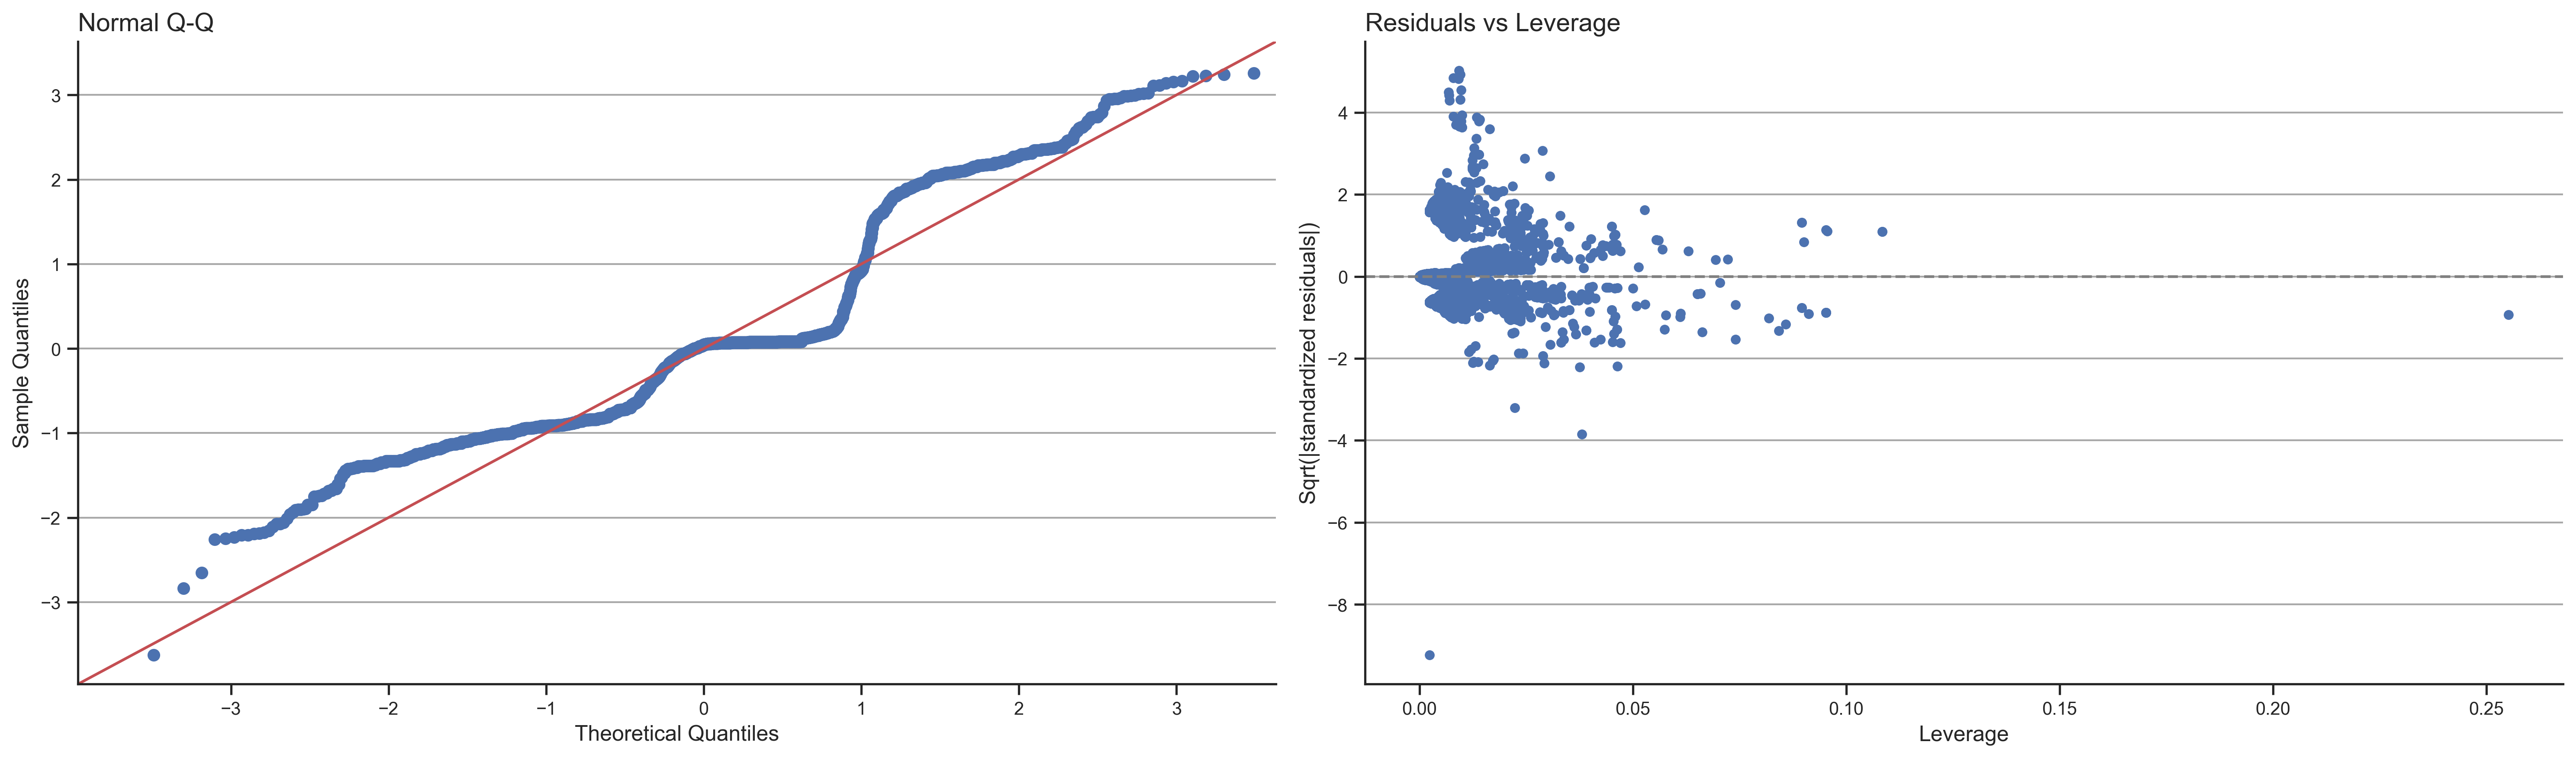

In [2236]:
#regression diagnostics - deviance residuals distribution and leverage plots for identification of influential outliers

plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style = 'white', rc = custom_params)

regression_stats_df = pd.DataFrame(dict(leverage = glm_bernoulli_m_opt.get_influence().hat_matrix_diag,
                                        residuals = glm_bernoulli_m_opt.resid_deviance,
                                        fittedvalues = glm_bernoulli_m_opt.fittedvalues,
                                        residuals_std = glm_bernoulli_m_opt.resid_pearson))

sm.qqplot(regression_stats_df['residuals'], dist = st.norm, fit = True, line = '45', ax = ax[0], c = '#4C72B0')
ax[0].set_title('Normal Q-Q', fontsize = 14, loc = 'left')
ax[0].tick_params(labelsize = 10)
ax[0].tick_params(bottom = True, left = True)
ax[0].yaxis.grid(True, color = '#A9A9A9')
ax[0].xaxis.grid(False)

# Standardized residuals vs. leverage
regression_stats_df.plot.scatter(x = 'leverage', y = 'residuals_std', ax = ax[1])
ax[1].axhline(y = 0, color = 'grey', linestyle = 'dashed')
ax[1].set_xlabel('Leverage')
ax[1].set_ylabel('Sqrt(|standardized residuals|)')
ax[1].set_title('Residuals vs Leverage', fontsize = 14, loc = 'left')
ax[1].tick_params(labelsize = 10)
ax[1].tick_params(bottom = True, left = True)
ax[1].yaxis.grid(True, color = '#A9A9A9')
ax[1].xaxis.grid(False)

plt.tight_layout()
plt.show()
fig.savefig('Figures/regression_diagnostics.png', format = 'png', dpi = 300)

In [2238]:
#fucntion for predicting multivariate regression probabilities
def predict_probability_multivariate(model, x_val):
    intercept = model.params.to_numpy()[0]
    expl = model.params.to_numpy()[1:]
    log_odds = intercept + (x_val[list(model.params.index[1:])].to_numpy() @ expl)
    return np.exp(log_odds) / (1 + np.exp(log_odds))

In [2240]:
#area under the curve metric calculation and formation of a classification report
fpr, tpr, thresholds = roc_curve(response_var, predict_probability_multivariate(glm_bernoulli_m_opt, expl_var_m))
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

refund_pred_roc = (predict_probability_multivariate(glm_bernoulli_m_opt, expl_var_m) >= optimal_threshold).astype('int8')
refund_pred_eq = (predict_probability_multivariate(glm_bernoulli_m_opt, expl_var_m) >= 0.5).astype('int8')
roc_auc = roc_auc_score(response_var, predict_probability_multivariate(glm_bernoulli_m_opt, expl_var_m))

print(f'Optimal ROC Threshold: {optimal_threshold:.2f} (AUC: {roc_auc:.2f})')
print(classification_report(response_var, refund_pred_roc))
print(f'Threshold: 0.5')
print(classification_report(response_var, refund_pred_eq))

Optimal ROC Threshold: 0.28 (AUC: 0.89)
              precision    recall  f1-score   support

           0       0.90      0.79      0.85      3052
           1       0.58      0.77      0.66      1114

    accuracy                           0.79      4166
   macro avg       0.74      0.78      0.75      4166
weighted avg       0.82      0.79      0.80      4166

Threshold: 0.5
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      3052
           1       0.88      0.49      0.63      1114

    accuracy                           0.85      4166
   macro avg       0.86      0.73      0.77      4166
weighted avg       0.85      0.85      0.83      4166



In [2242]:
#function for a test of a model prediction stability by fitting regression on subset of data comprising 70% of original data
#and validating it on the reaining 30% test dataset
def test_model_assessment(model, feauture_df, response_var, test_size = 0.3, iterations = 10):

    roc_auc_scores = []
    accuracy_opt_scores = []
    accuracy_eq_scores = []

    for i in range(iterations):
        x_train, x_test, y_train, y_test = train_test_split(feauture_df[list(model.params.index)],
                                                            response_var, test_size = test_size, shuffle = True, stratify = response_var)
        glm_bernoilli_test = sm.GLM(y_train, x_train, family = sm.families.Binomial()).fit()
    
        fpr, tpr, thresholds = roc_curve(y_test, predict_probability_multivariate(glm_bernoilli_test, x_test))
        optimal_idx = (tpr - fpr).argmax()
        optimal_threshold = thresholds[optimal_idx]
        
        refund_pred_roc = (predict_probability_multivariate(glm_bernoilli_test, x_test) >= optimal_threshold).astype('int8')
        refund_pred_eq = (predict_probability_multivariate(glm_bernoilli_test, x_test) >= 0.5).astype('int8')
        roc_auc = roc_auc_score(y_test, predict_probability_multivariate(glm_bernoilli_test, x_test))
        accuracy_opt = accuracy_score(y_test, refund_pred_roc)
        accuracy_eq = accuracy_score(y_test, refund_pred_eq)

        roc_auc_scores.append(roc_auc)
        accuracy_opt_scores.append(accuracy_opt)
        accuracy_eq_scores.append(accuracy_eq)

    return np.array(roc_auc_scores), np.array(accuracy_opt_scores), np.array(accuracy_eq_scores)

In [2244]:
#calculation of average model precision metrics (accuracy, auc scores) among all random training iterations
roc_auc_scores, accuracy_opt_scores, accuracy_eq_scores = test_model_assessment(glm_bernoulli_m_opt,
                                                    expl_var_m, response_var, test_size = 0.3, iterations = 10)

print('Mean ROC-AUC scores: {0}. Standard deviation: {1}.'.format(round(roc_auc_scores.mean(), 3), round(roc_auc_scores.std(ddof = 1), 3)),
      'Mean Accuracy scores (optimal cutoff): {0}. Standard deviation: {1}.'.format(round(accuracy_opt_scores.mean(), 3), round(accuracy_opt_scores.std(ddof = 1), 3)),
      'Mean Accuracy scores (0.5 cutoff): {0}. Standard deviation: {1}.'.format(round(accuracy_eq_scores.mean(), 3), round(accuracy_eq_scores.std(ddof = 1), 3)),
      sep = '\n')


Mean ROC-AUC scores: 0.88. Standard deviation: 0.005.
Mean Accuracy scores (optimal cutoff): 0.77. Standard deviation: 0.044.
Mean Accuracy scores (0.5 cutoff): 0.846. Standard deviation: 0.008.


In [2245]:
##variance inflation factor computation for the design matrix 
vif = pd.DataFrame()
vif['Variable'] = glm_bernoulli_m_opt.params.index
vif['VIF'] = [variance_inflation_factor(expl_var_m[list(glm_bernoulli_m_opt.params.index)].values, i)
                                      for i in range(len(glm_bernoulli_m_opt.params.index))]

vif.sort_values('VIF', ascending = False).query('VIF > 10').reset_index(drop = True)

Variable        VIF
0                           Departure.Daytime_Evening        inf
1   Journey.Status_Cancelled_x_Departure.Daytime_E...        inf
2                                               const  68.359575
3                                      DelayInMinutes  49.126472
4                                     Travel.Duration  28.370567
5                                               Price  26.988189
6                                   Travel.Duration^2  20.675533
7                                    DelayInMinutes^2  19.198316
8                                             Price^2  14.093852
9                            Journey.Status_Cancelled  13.598053
10  Journey.Status_Cancelled_x_Scheduled.Arrival.D...  13.411311
11                   Travel.Duration_x_DelayInMinutes  13.119417

## Alternative model

In [2248]:
#refund rate discretization by features
#relative refund rates observed on the level of different categories are used to derive location and time discrete features
#station and route refund rates
trips_refund_eligible['Departure.Refund.Rate'] = trips_refund_eligible \
                            .assign(refund = trips_refund_eligible['Refund.Request'] == 'Yes') \
                                .groupby(['Departure.Station'])['refund'].transform('mean')
trips_refund_eligible['Arrival.Refund.Rate'] = trips_refund_eligible \
                            .assign(refund = trips_refund_eligible['Refund.Request'] == 'Yes') \
                                .groupby(['Arrival.Station'])['refund'].transform('mean')
trips_refund_eligible['Route.Refund.Rate'] = trips_refund_eligible \
                            .assign(refund = trips_refund_eligible['Refund.Request'] == 'Yes') \
                                .groupby(['Departure.Station', 'Arrival.Station'])['refund'].transform('mean')

#departures and arrival daytime refund rates
trips_refund_eligible['Departure.Daytime.Refund.Rate'] = trips_refund_eligible \
                            .assign(refund = trips_refund_eligible['Refund.Request'] == 'Yes') \
                                .groupby(['Departure.Daytime'])['refund'].transform('mean')
trips_refund_eligible['Arrival.Daytime.Refund.Rate'] = trips_refund_eligible \
                            .assign(refund = trips_refund_eligible['Refund.Request'] == 'Yes') \
                                .groupby(['Scheduled.Arrival.Daytime'])['refund'].transform('mean')


#discrete departure station refund rate
discrete_rd = KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'quantile', subsample = None)
discrete_rd.fit(trips_refund_eligible \
                    .assign(refund = trips_refund_eligible['Refund.Request'] == 'Yes') \
                        .groupby(['Departure.Station'])['refund'].mean().to_numpy().reshape(-1, 1))
trips_refund_eligible['Departure.Refund.Rate'] = discrete_rd.transform(trips_refund_eligible['Departure.Refund.Rate'].to_numpy() \
                                                        .reshape(-1, 1))
trips_refund_eligible['Departure.Refund.Rate'] = trips_refund_eligible['Departure.Refund.Rate'].astype('int8').replace({0 : 'Low', 1 : 'Medium', 2 : 'High'})

#discrete arrival station refund rate
discrete_ra = KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'quantile', subsample = None)
discrete_ra.fit(trips_refund_eligible \
                    .assign(refund = trips_refund_eligible['Refund.Request'] == 'Yes') \
                        .groupby(['Arrival.Station'])['refund'].mean().to_numpy().reshape(-1, 1))
trips_refund_eligible['Arrival.Refund.Rate'] = discrete_ra.transform(trips_refund_eligible['Arrival.Refund.Rate'].to_numpy() \
                                                        .reshape(-1, 1))
trips_refund_eligible['Arrival.Refund.Rate'] = trips_refund_eligible['Arrival.Refund.Rate'].astype('int8').replace({0 : 'Low', 1 : 'Medium', 2 : 'High'})

#discrete route refund rate
discrete_rr = KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'quantile', subsample = None)
discrete_rr.fit(trips_refund_eligible \
                    .assign(refund = trips_refund_eligible['Refund.Request'] == 'Yes') \
                        .groupby(['Departure.Station', 'Arrival.Station'])['refund'].mean().to_numpy().reshape(-1, 1))
trips_refund_eligible['Route.Refund.Rate'] = discrete_rr.transform(trips_refund_eligible['Route.Refund.Rate'].to_numpy() \
                                                        .reshape(-1, 1))
trips_refund_eligible['Route.Refund.Rate'] = trips_refund_eligible['Route.Refund.Rate'].astype('int8').replace({0 : 'Low', 1 : 'Medium', 2 : 'High'})

#discrete departure daytime refund rate
discrete_rday_d = KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'quantile', subsample = None)
discrete_rday_d.fit(trips_refund_eligible \
                    .assign(refund = trips_refund_eligible['Refund.Request'] == 'Yes') \
                        .groupby(['Departure.Daytime'])['refund'].mean().to_numpy().reshape(-1, 1))
trips_refund_eligible['Departure.Daytime.Refund.Rate'] = discrete_rday_d.transform(trips_refund_eligible['Departure.Daytime.Refund.Rate'].to_numpy() \
                                                        .reshape(-1, 1))
trips_refund_eligible['Departure.Daytime.Refund.Rate'] = trips_refund_eligible['Departure.Daytime.Refund.Rate'].astype('int8').replace({0 : 'Low', 1 : 'Medium', 2 : 'High'})

#discrete arrival departure daytime refund rate
discrete_rday_a = KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'quantile', subsample = None)
discrete_rday_a.fit(trips_refund_eligible \
                    .assign(refund = trips_refund_eligible['Refund.Request'] == 'Yes') \
                        .groupby(['Scheduled.Arrival.Daytime'])['refund'].mean().to_numpy().reshape(-1, 1))
trips_refund_eligible['Arrival.Daytime.Refund.Rate'] = discrete_rday_a.transform(trips_refund_eligible['Arrival.Daytime.Refund.Rate'].to_numpy() \
                                                        .reshape(-1, 1))
trips_refund_eligible['Arrival.Daytime.Refund.Rate'] = trips_refund_eligible['Arrival.Daytime.Refund.Rate'].astype('int8').replace({0 : 'Low', 1 : 'Medium', 2 : 'High'})

In [2250]:
#dummy variables creation
dummy_columns = ['Journey.Status', 'Payment.Method', 'Railcard', 'Ticket.Class', 'Ticket.Type',
                 'Departure.Daytime.Refund.Rate', 'Arrival.Daytime.Refund.Rate',
                 'Departure.Refund.Rate', 'Arrival.Refund.Rate', 'Route.Refund.Rate']

baseline_vals = ['Delayed', 'Contactless', 'None', 'Standard', 'Advance',
                 'Low', 'Low', 'Low', 'Low', 'Low']

dummy_df = pd.get_dummies(trips_refund_eligible, prefix = dummy_columns, prefix_sep = '_',
                          columns = dummy_columns, sparse = False, drop_first = False, dtype = 'int8')

dummy_names = dummy_df.columns[[col.startswith(tuple([col + '_' for col in dummy_columns])) for col in dummy_df.columns]]
dummy_df = dummy_df[dummy_names]
dummy_df.drop(columns = [pref + '_' + val for pref, val in zip(dummy_columns, baseline_vals)], inplace = True)

In [2252]:
#continuous features polynomials and interactions
polynom = PolynomialFeatures(degree = 2, interaction_only = False, include_bias = False)
polynom_df = pd.DataFrame(polynom.fit_transform(trips_refund_eligible[['Price', 'Travel.Duration', 'DelayInMinutes']].fillna(0)),
                          columns = [name.replace(' ', '_x_')for name in polynom.get_feature_names_out()])
polynom_df = polynom_df[sorted(list(polynom_df.columns))]

#dummy feature interactions
interaction_cols = list(dummy_df.drop(columns = ['Journey.Status_Cancelled']).columns) \
                                            + ['Price', 'Travel.Duration']

interaction_df = var_df_interaction('Journey.Status_Cancelled', interaction_cols,
                                        pd.concat([dummy_df, polynom_df], axis = 1))

In [2254]:
#full model fit
response_var = np.where(trips_refund_eligible['Refund.Request'] == 'Yes', 1, 0)
expl_var_m_a = pd.concat([dummy_df, polynom_df, interaction_df], axis = 1)
expl_var_m_a = sm.add_constant(expl_var_m_a)
glm_bernoulli_m_a = sm.GLM(response_var, expl_var_m_a, family = sm.families.Binomial())
glm_bernoulli_m_a = glm_bernoulli_m_a.fit()

glm_bernoulli_m_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 4166
Model:                            GLM   Df Residuals:                     4118
Model Family:                Binomial   Df Model:                           47
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1218.9
Date:                Fri, 22 Nov 2024   Deviance:                       2437.8
Time:                        10:13:30   Pearson chi2:                 2.56e+03
No. Iterations:                    24   Pseudo R-squ. (CS):             0.4379
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                             -14.5603      1.937     -7.515      0.000     -18.357     -10.763
Journey.Status_Cancelled                                           13.4407      1.940      6.929      0.000       9.639      17.242
Payment.Method_Credit Card                                          3.8863      0.684      5.683      0.000       2.546       5.227
Payment.Method_Debit Card                                          10.3906      1.151      9.025      0.000       8.134      12.647
Railcard_Adult                                                     -3.7480      1.199     -3.127      0.002      -6.097      -1.399
Railcard_Disabled                                                 -32.6802    1.3e+04     -0.003      0.998   -2.55e+04    2.54e+04
Railcard_Senior                                                    -1.3012      1.830     -0.711      0.477      -4.888       2.286
Ticket.Class_First Class                                           -1.8609      0.803     -2.316      0.021      -3.435      -0.286
Ticket.Type_Anytime                                                -2.5184      0.742     -3.395      0.001      -3.972      -1.064
Ticket.Type_Off-Peak                                               -0.2853      0.457     -0.624      0.532      -1.181       0.610
Departure.Daytime.Refund.Rate_High                                 -2.2532      1.538     -1.465      0.143      -5.269       0.762
Departure.Daytime.Refund.Rate_Medium                                2.7850      1.185      2.351      0.019       0.463       5.107
Arrival.Daytime.Refund.Rate_High                                    9.8266      1.616      6.080      0.000       6.659      12.994
Arrival.Daytime.Refund.Rate_Medium                                  7.4161      1.314      5.643      0.000       4.840       9.992
Departure.Refund.Rate_High                                          8.8332      3.501      2.523      0.012       1.971      15.695
Departure.Refund.Rate_Medium                                        1.6039      1.399      1.146      0.252      -1.138       4.346
Arrival.Refund.Rate_High                                           -0.1319      1.011     -0.130      0.896      -2.114       1.850
Arrival.Refund.Rate_Medium                                        -14.4488      2.427     -5.953      0.000     -19.206      -9.691
Route.Refund.Rate_High                                              0.6773      1.009      0.671      0.502      -1.301       2.655
Route.Refund.Rate_Medium                                            2.4638      1.135      2.170      0.030       0.239       4.689
DelayInMinutes                                 

In [2256]:
#feature selection
glm_bernoulli_m_opt_a = select_features(glm_bernoulli_m_a, expl_var_m_a, response_var, p_threshold = 0.05)
glm_bernoulli_m_opt_a.summary()

p-value_1: 0.0
p-value_2: 1.0
p-value_3: 0.98
p-value_4: 0.88
p-value_5: 0.38
p-value_6: 0.57
p-value_7: 0.53
p-value_8: 0.63
p-value_9: 0.01


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 4166
Model:                            GLM   Df Residuals:                     4126
Model Family:                Binomial   Df Model:                           39
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1249.3
Date:                Fri, 22 Nov 2024   Deviance:                       2498.6
Time:                        10:13:39   Pearson chi2:                 9.30e+03
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4297
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                             -18.1502      1.835     -9.891      0.000     -21.747     -14.554
Journey.Status_Cancelled                                           16.9000      1.846      9.153      0.000      13.281      20.519
Payment.Method_Credit Card                                          3.8890      0.638      6.100      0.000       2.639       5.139
Payment.Method_Debit Card                                           7.4494      0.819      9.094      0.000       5.844       9.055
Railcard_Adult                                                      3.9813      0.666      5.979      0.000       2.676       5.286
Railcard_Senior                                                     8.8469      1.443      6.129      0.000       6.018      11.676
Ticket.Class_First Class                                           -1.5304      0.654     -2.339      0.019      -2.813      -0.248
Ticket.Type_Anytime                                                -2.5446      0.783     -3.251      0.001      -4.079      -1.011
Departure.Daytime.Refund.Rate_High                                  8.0765      1.249      6.465      0.000       5.628      10.525
Departure.Daytime.Refund.Rate_Medium                                6.9123      1.015      6.810      0.000       4.923       8.902
Arrival.Daytime.Refund.Rate_High                                    2.5480      0.977      2.607      0.009       0.632       4.464
Arrival.Daytime.Refund.Rate_Medium                                  2.1137      0.812      2.605      0.009       0.523       3.704
Departure.Refund.Rate_High                                          8.6312      5.283      1.634      0.102      -1.723      18.986
Departure.Refund.Rate_Medium                                        5.0441      1.804      2.796      0.005       1.509       8.579
Arrival.Refund.Rate_High                                           -4.9880      1.158     -4.306      0.000      -7.258      -2.718
Arrival.Refund.Rate_Medium                                        -17.3412      2.941     -5.895      0.000     -23.106     -11.576
Route.Refund.Rate_High                                             -4.2155      1.159     -3.638      0.000      -6.487      -1.944
Route.Refund.Rate_Medium                                            7.3857      1.323      5.581      0.000       4.792       9.979
DelayInMinutes                                                      0.0972      0.033      2.960      0.003       0.033       0.162
DelayInMinutes^2                                                   -0.0019      0.001     -3.703      0.000      -0.003      -0.001
Price                                          

In [2258]:
##design matrix variance inflation factor estimation
vif = pd.DataFrame()
vif['Variable'] = glm_bernoulli_m_opt_a.params.index
vif['VIF'] = [variance_inflation_factor(expl_var_m_a[list(glm_bernoulli_m_opt_a.params.index)].values, i)
                                      for i in range(len(glm_bernoulli_m_opt_a.params.index))]

vif.sort_values('VIF', ascending = False).query('VIF > 10').reset_index(drop = True)

Variable        VIF
0                            Arrival.Refund.Rate_High        inf
1   Journey.Status_Cancelled_x_Route.Refund.Rate_High        inf
2   Journey.Status_Cancelled_x_Arrival.Refund.Rate...        inf
3                              Route.Refund.Rate_High        inf
4                                               const  63.063867
5                                               Price  42.422856
6                          Arrival.Refund.Rate_Medium  30.927352
7                            Journey.Status_Cancelled  24.836974
8   Journey.Status_Cancelled_x_Arrival.Refund.Rate...  24.072742
9                                      DelayInMinutes  19.679362
10                                            Price^2  16.519608
11         Journey.Status_Cancelled_x_Travel.Duration  14.707568
12                                   DelayInMinutes^2  12.836503
13                       Departure.Refund.Rate_Medium  12.457368
14  Journey.Status_Cancelled_x_Route.Refund.Rate_M...  10.658769

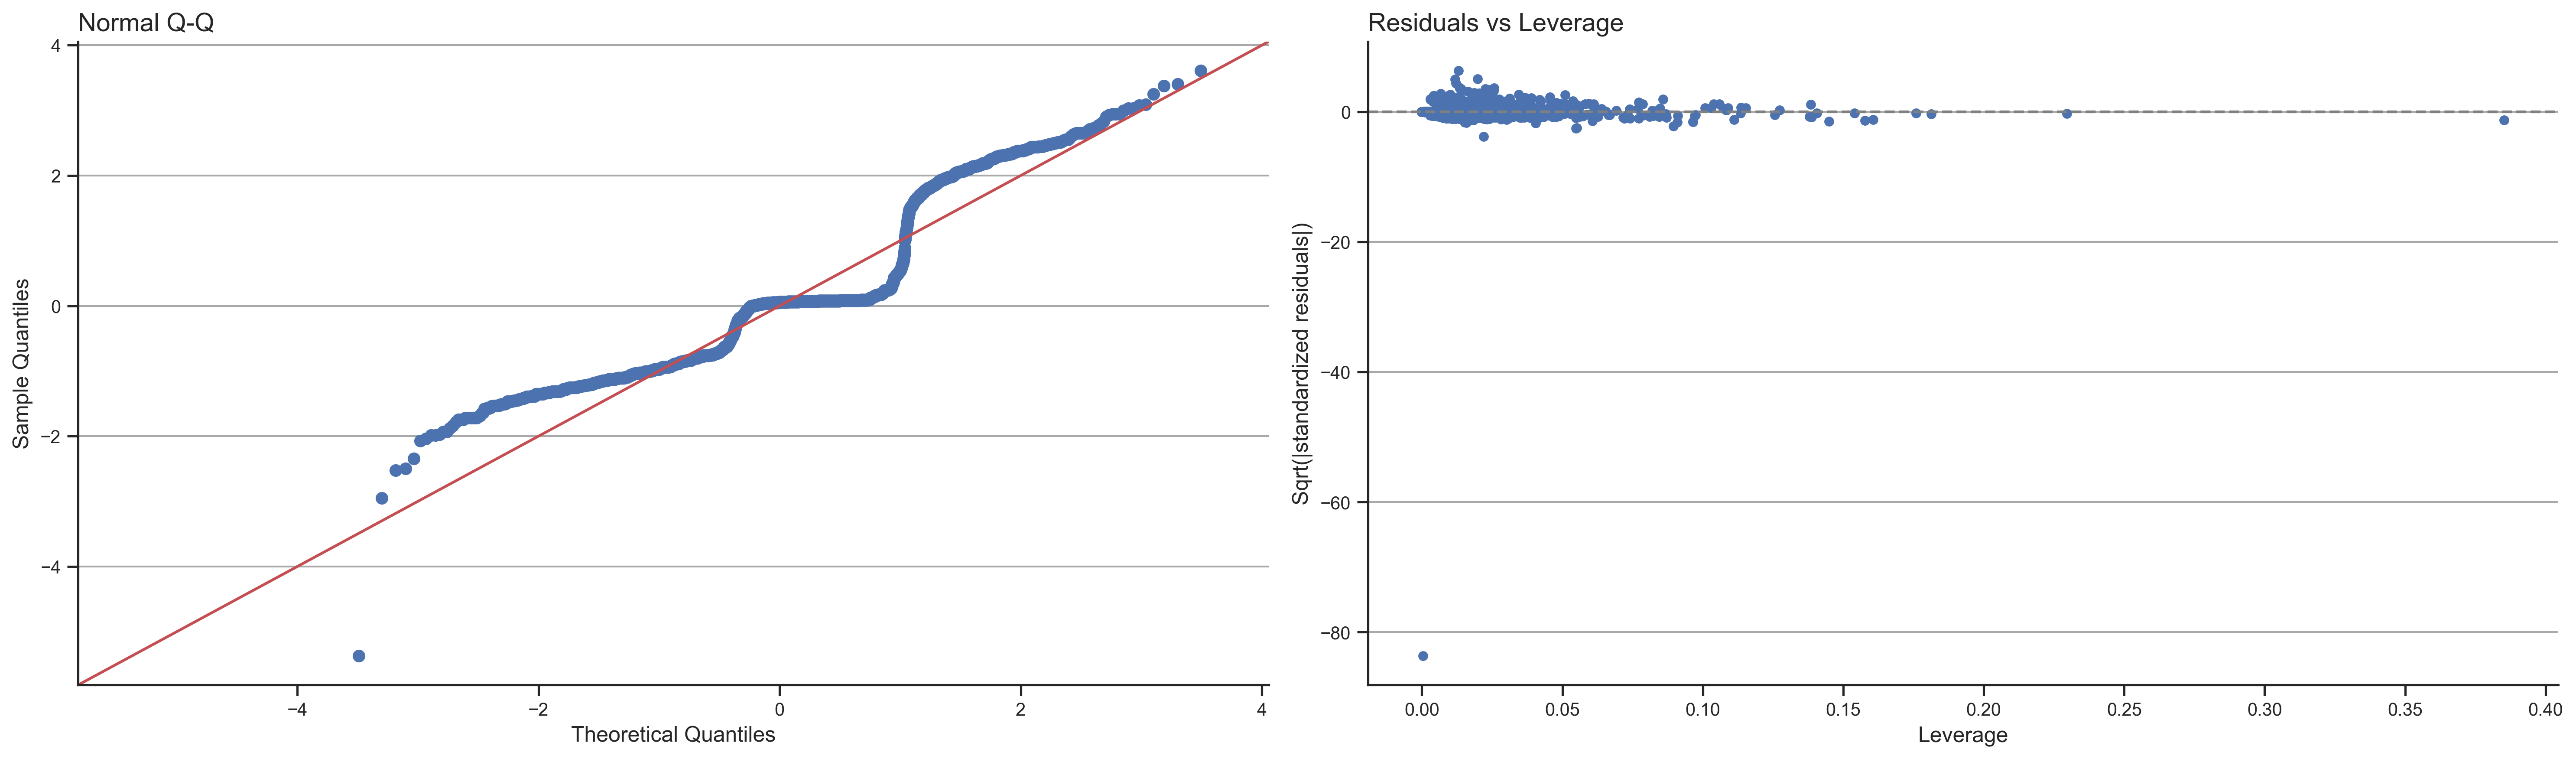

In [2260]:
#regression diagnostics

plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style = 'white', rc = custom_params)

regression_stats_df = pd.DataFrame(dict(leverage = glm_bernoulli_m_opt_a.get_influence().hat_matrix_diag,
                                        residuals = glm_bernoulli_m_opt_a.resid_deviance,
                                        fittedvalues = glm_bernoulli_m_opt_a.fittedvalues,
                                        residuals_std = glm_bernoulli_m_opt_a.resid_pearson))

sm.qqplot(regression_stats_df['residuals'], dist = st.norm, fit = True, line = '45', ax = ax[0], c = '#4C72B0')
ax[0].set_title('Normal Q-Q', fontsize = 14, loc = 'left')
ax[0].tick_params(labelsize = 10)
ax[0].tick_params(bottom = True, left = True)
ax[0].yaxis.grid(True, color = '#A9A9A9')
ax[0].xaxis.grid(False)

# Standardized residuals vs. leverage
regression_stats_df.plot.scatter(x = 'leverage', y = 'residuals_std', ax = ax[1])
ax[1].axhline(y = 0, color = 'grey', linestyle = 'dashed')
ax[1].set_xlabel('Leverage')
ax[1].set_ylabel('Sqrt(|standardized residuals|)')
ax[1].set_title('Residuals vs Leverage', fontsize = 14, loc = 'left')
ax[1].tick_params(labelsize = 10)
ax[1].tick_params(bottom = True, left = True)
ax[1].yaxis.grid(True, color = '#A9A9A9')
ax[1].xaxis.grid(False)

plt.tight_layout()
plt.show()
fig.savefig('Figures/regression_diagnostics_a.png', format = 'png', dpi = 300)

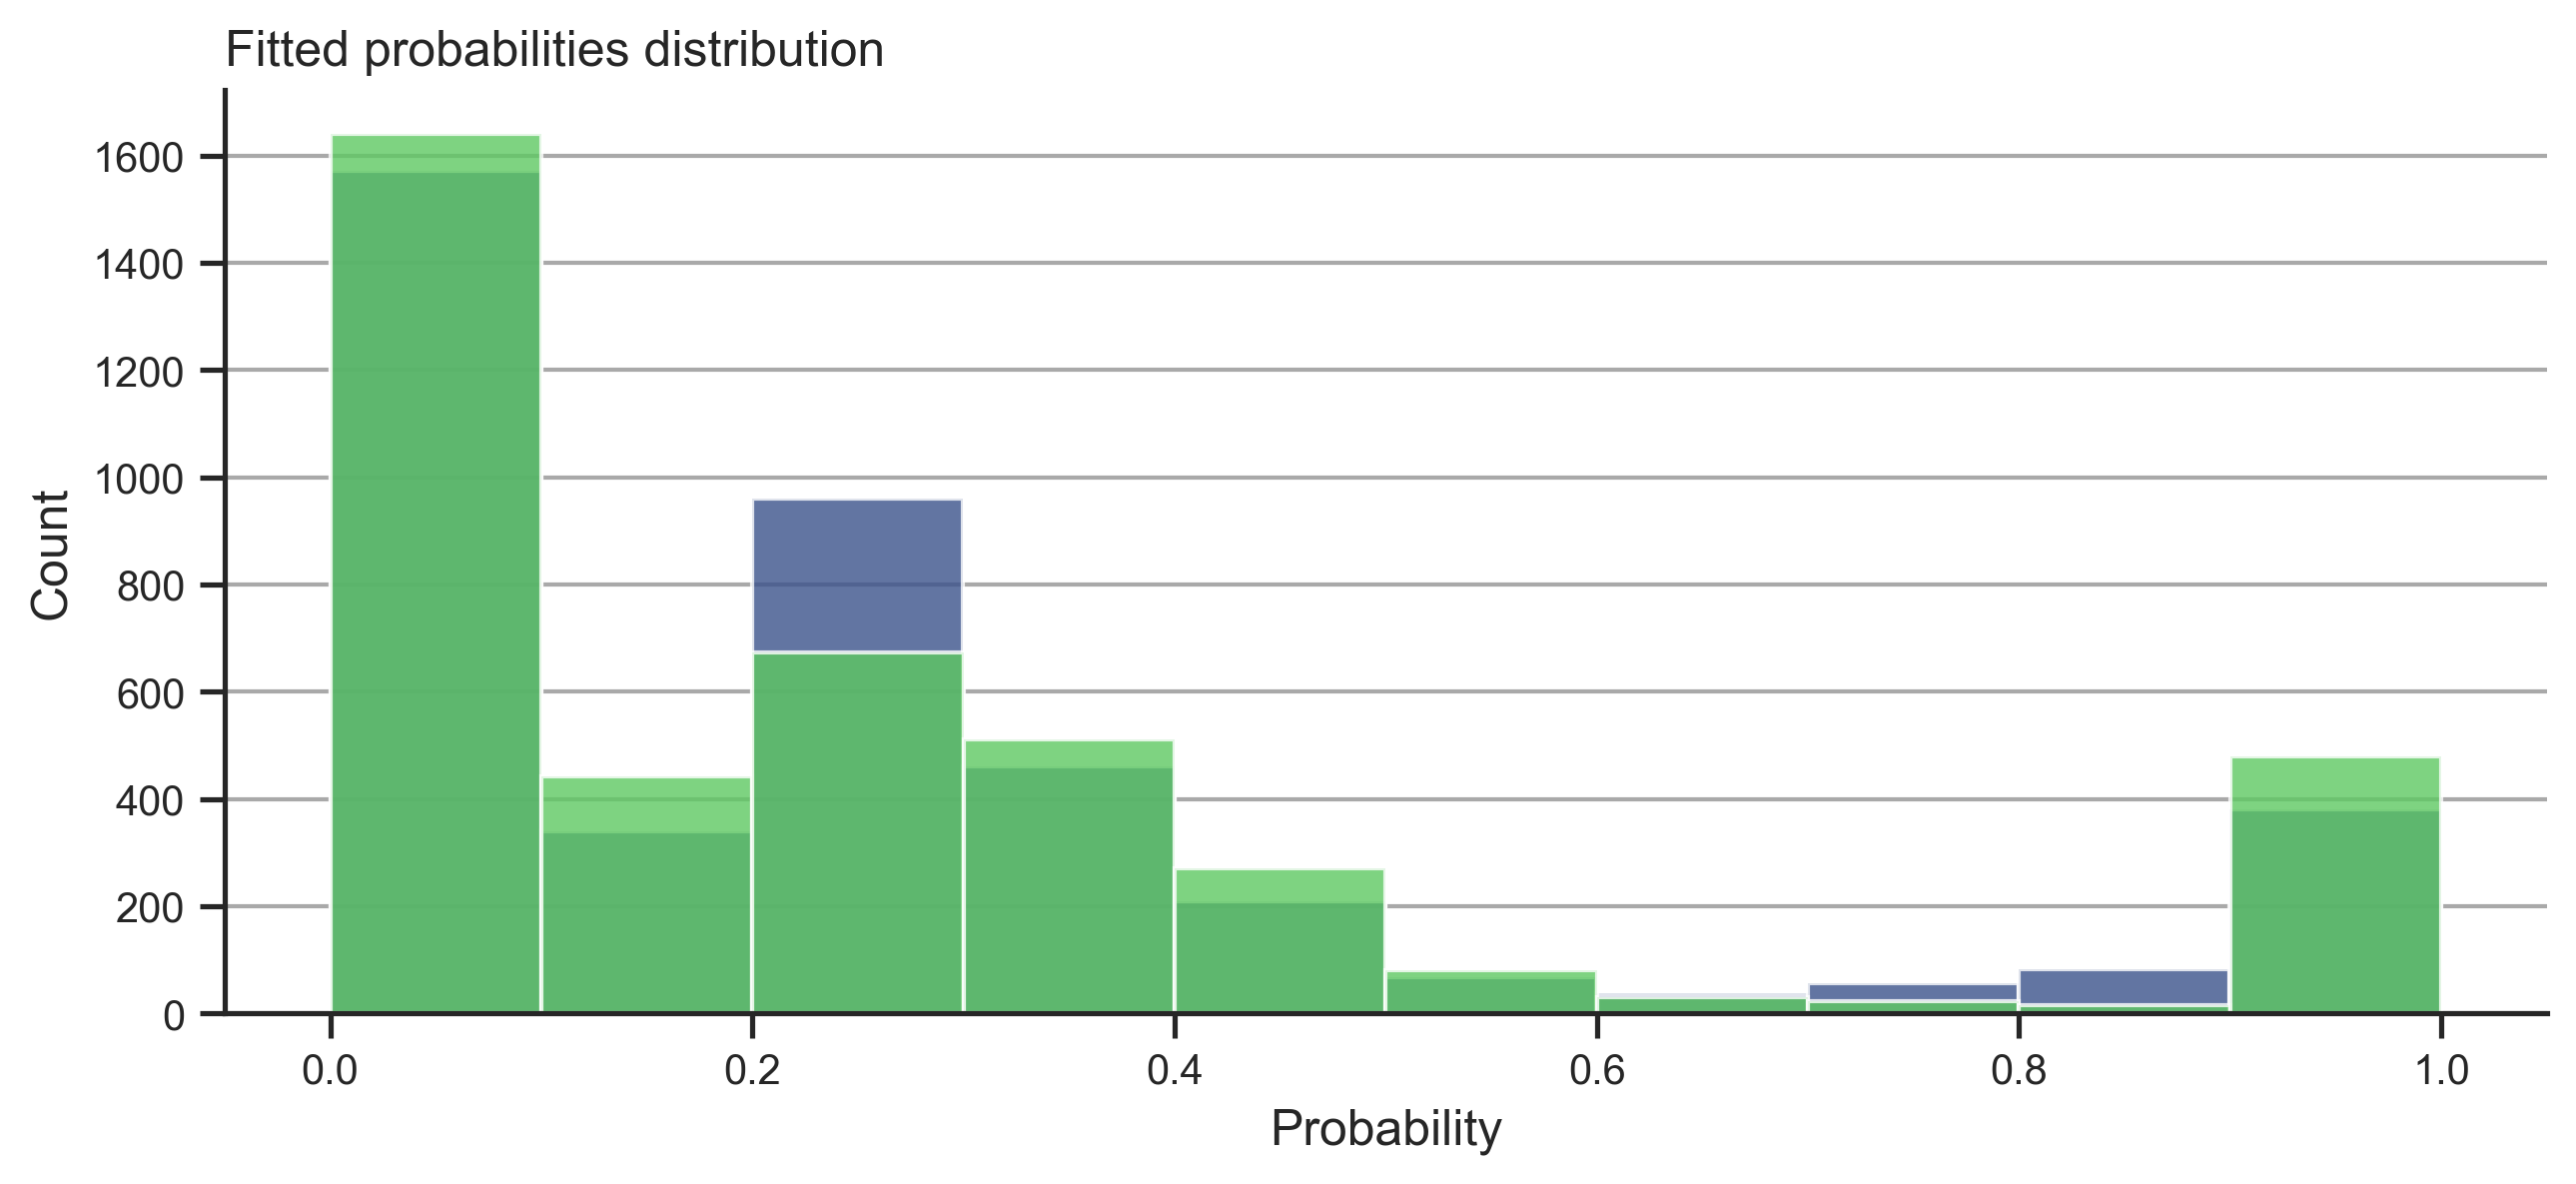

In [2262]:
#difference in models' fitted probability distributions

plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, figsize = (10, 4))
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style = 'white', rc = custom_params)

pd.Series(predict_probability_multivariate(glm_bernoulli_m_opt, expl_var_m)).hist(color = '#3B528B', alpha = 0.8)
pd.Series(predict_probability_multivariate(glm_bernoulli_m_opt_a, expl_var_m_a)).hist(color = '#5EC962', alpha = 0.8)
ax.set_xlabel('Probability')
ax.set_ylabel('Count')
ax.set_title('Fitted probabilities distribution', fontsize = 12, loc = 'left')
ax.tick_params(labelsize = 10)
ax.tick_params(bottom = True, left = True)
ax.yaxis.grid(True, color = '#A9A9A9')
ax.xaxis.grid(False)

plt.show()
fig.savefig('Figures/fitted_pobabilities.png', format = 'png', dpi = 300)

In [2264]:
#classification report
fpr_a, tpr_a, thresholds_a = roc_curve(response_var, predict_probability_multivariate(glm_bernoulli_m_opt_a, expl_var_m_a))
optimal_idx = (tpr - fpr).argmax()
optimal_threshold_a = thresholds_a[optimal_idx]

refund_pred_roc = (predict_probability_multivariate(glm_bernoulli_m_opt_a, expl_var_m_a) >= optimal_threshold_a).astype('int8')
refund_pred_eq = (predict_probability_multivariate(glm_bernoulli_m_opt_a, expl_var_m_a) >= 0.5).astype('int8')
roc_auc = roc_auc_score(response_var, predict_probability_multivariate(glm_bernoulli_m_opt_a, expl_var_m_a))

print(f'Optimal ROC Threshold: {optimal_threshold:.2f} (AUC: {roc_auc:.2f})')
print(classification_report(response_var, refund_pred_roc))
print(f'Threshold: 0.5')
print(classification_report(response_var, refund_pred_eq))

Optimal ROC Threshold: 0.28 (AUC: 0.90)
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      3052
           1       0.62      0.76      0.69      1114

    accuracy                           0.81      4166
   macro avg       0.76      0.80      0.78      4166
weighted avg       0.83      0.81      0.82      4166

Threshold: 0.5
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      3052
           1       0.90      0.51      0.65      1114

    accuracy                           0.85      4166
   macro avg       0.87      0.74      0.78      4166
weighted avg       0.86      0.85      0.84      4166



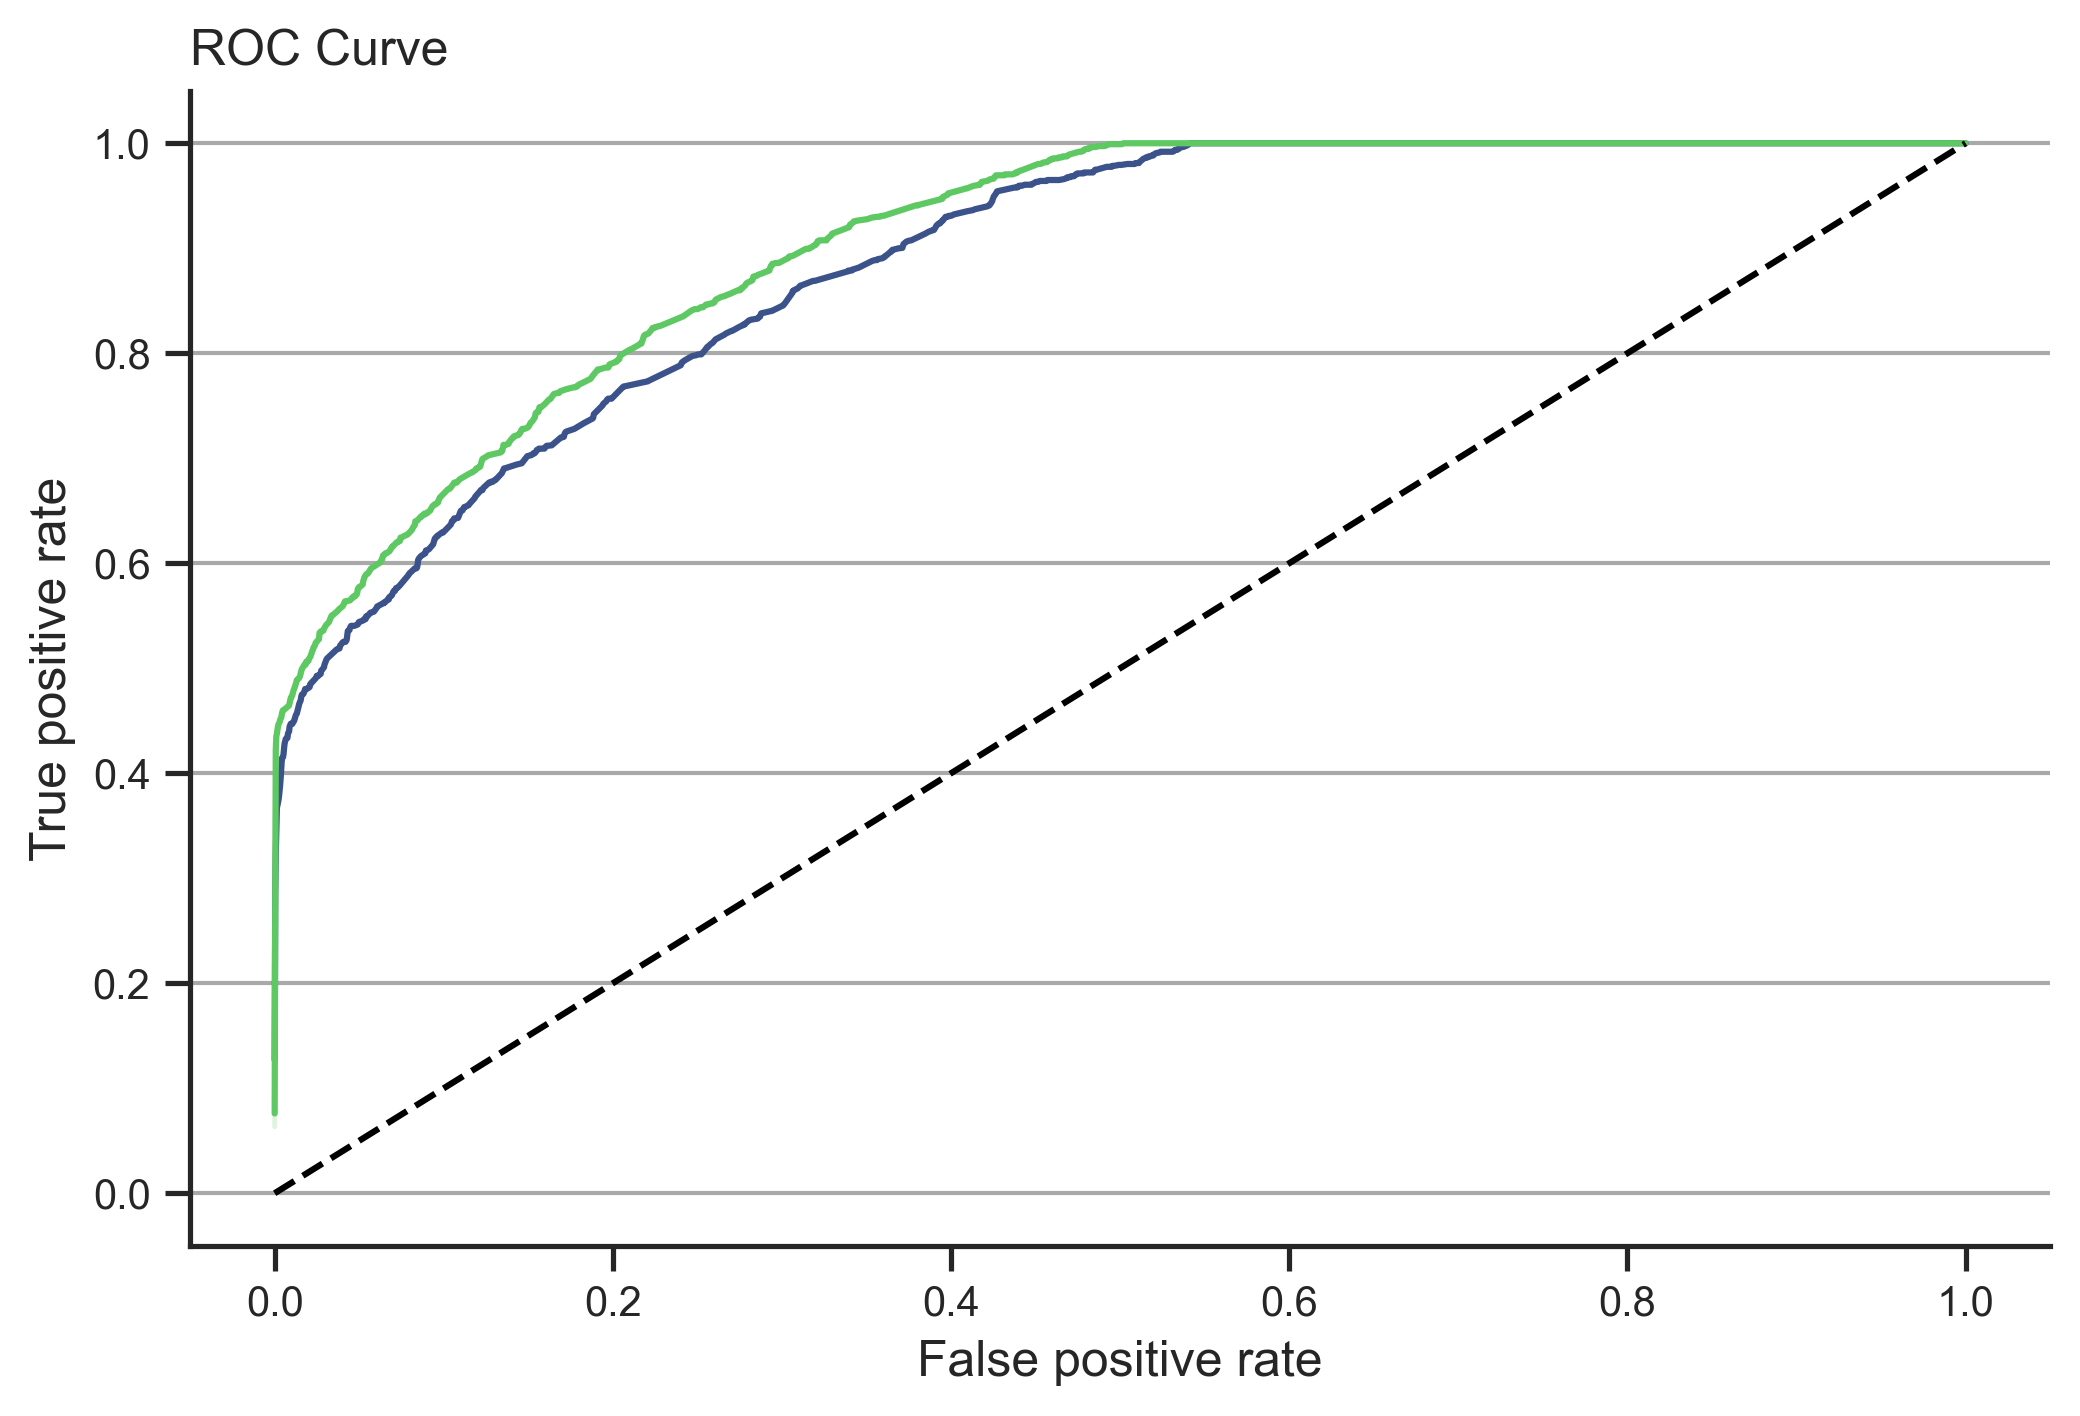

In [2266]:
#roc curve plotting
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, figsize = (8, 5))
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style = 'white', rc = custom_params)

sns.lineplot(x = fpr, y = tpr, color = '#3B528B')
sns.lineplot(x = fpr_a, y = tpr_a, color = '#5EC962')
plt.plot([0, 1], [0, 1], 'k--', color = 'black')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC Curve', fontsize = 12, loc = 'left')
ax.tick_params(labelsize = 10)
ax.tick_params(bottom = True, left = True)
ax.yaxis.grid(True, color = '#A9A9A9')
ax.xaxis.grid(False)

plt.show()
fig.savefig('Figures/roc_curve.png', format = 'png', dpi = 300)

In [2268]:
#iterative model validation by training and predicting on different random subsets of data

roc_auc_scores, accuracy_opt_scores, accuracy_eq_scores = test_model_assessment(glm_bernoulli_m_opt_a,
                                                    expl_var_m_a, response_var, test_size = 0.3, iterations = 10)

print('Mean ROC-AUC scores: {0}. Standard deviation: {1}.'.format(round(roc_auc_scores.mean(), 3), round(roc_auc_scores.std(ddof = 1), 3)),
      'Mean Accuracy scores (optimal cutoff): {0}. Standard deviation: {1}.'.format(round(accuracy_opt_scores.mean(), 3), round(accuracy_opt_scores.std(ddof = 1), 3)),
      'Mean Accuracy scores (0.5 cutoff): {0}. Standard deviation: {1}.'.format(round(accuracy_eq_scores.mean(), 3), round(accuracy_eq_scores.std(ddof = 1), 3)),
      sep = '\n')


Mean ROC-AUC scores: 0.896. Standard deviation: 0.005.
Mean Accuracy scores (optimal cutoff): 0.77. Standard deviation: 0.03.
Mean Accuracy scores (0.5 cutoff): 0.847. Standard deviation: 0.006.


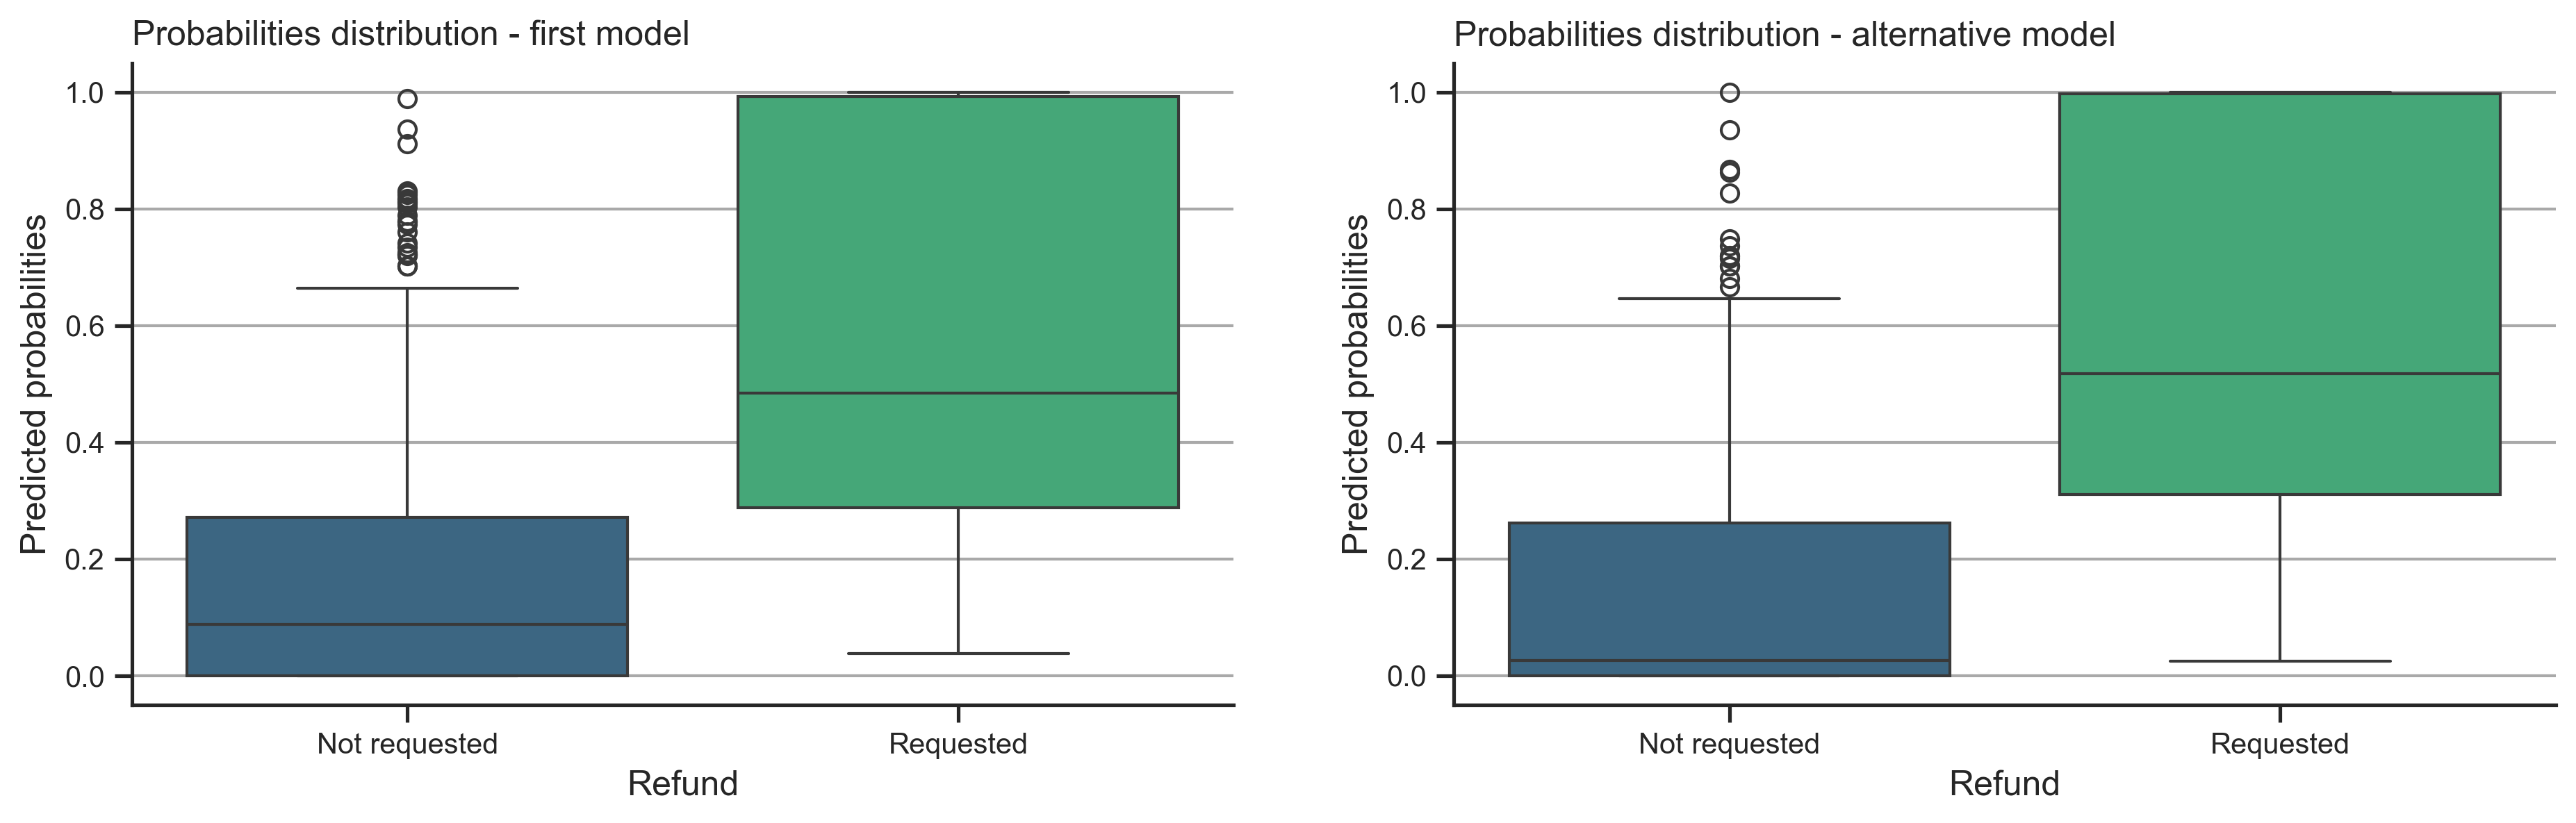

In [2269]:
#box-plots for predicted probability distributions broken down by the actual Refund request

plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style = 'white', rc = custom_params)

sns.boxplot(x = response_var, y = predict_probability_multivariate(glm_bernoulli_m_opt, expl_var_m),
                palette = 'viridis', ax = ax[0])
ax[0].set_xticks([0, 1], labels = ['Not requested', 'Requested'])
ax[0].set_xlabel('Refund')
ax[0].set_ylabel('Predicted probabilities')
ax[0].set_title('Probabilities distribution - first model', fontsize = 12, loc = 'left')
ax[0].tick_params(labelsize = 10)
ax[0].tick_params(bottom = True, left = True)
ax[0].yaxis.grid(True, color = '#A9A9A9')
ax[0].xaxis.grid(False)

sns.boxplot(x = response_var, y = predict_probability_multivariate(glm_bernoulli_m_opt_a, expl_var_m_a),
                palette = 'viridis', ax = ax[1])
ax[1].set_xticks([0, 1], labels = ['Not requested', 'Requested'])
ax[1].set_xlabel('Refund')
ax[1].set_ylabel('Predicted probabilities')
ax[1].set_title('Probabilities distribution - alternative model', fontsize = 12, loc = 'left')
ax[1].tick_params(labelsize = 10)
ax[1].tick_params(bottom = True, left = True)
ax[1].yaxis.grid(True, color = '#A9A9A9')
ax[1].xaxis.grid(False)

plt.show()
fig.savefig('Figures/boxplot_pred_prob.png', format = 'png', dpi = 300)

## External data prediction

In [2272]:
#function that replicates the data preprocessing pipeline and return a prediction for an external (test) dataset

def preprocess_predict(trips_df, model, ref_df = trips_refund_eligible, classification_threshold = 0.5, probability = False):

    #imputation

    trips_df['Departure'] = pd.to_datetime(trips_df['Departure'], format = '%Y-%m-%d %H:%M')
    trips_df['Scheduled.Arrival'] = pd.to_datetime(trips_df['Scheduled.Arrival'], format = '%Y-%m-%d %H:%M')
    trips_df['Actual.Arrival'] = pd.to_datetime(trips_df['Actual.Arrival'], format = '%Y-%m-%d %H:%M')
    
    trips_df['Departure'] = trips_df.apply(lambda x: impute_departure(x), axis = 1)
    trips_df['Scheduled.Arrival'] = trips_df.apply(lambda x: impute_arrival(x), axis = 1)
    
    trips_df.dropna(subset = ['Departure', 'Scheduled.Arrival'], inplace = True)
    trips_df.reset_index(drop = True, inplace = True)

    #NA cleaning
    trips_df['Railcard'] = trips_df['Railcard'].fillna('None')

    #feature engineering and extraction

    trips_df['Travel.Duration'] = (trips_df['Scheduled.Arrival'] - trips_df['Departure']).dt.total_seconds()/60
    trips_df['Travel.Delay'] = (trips_df['Actual.Arrival'] - trips_df['Scheduled.Arrival']).dt.total_seconds()/60
    
    trips_df['Departure.Daytime'] = trips_df['Departure'].dt.hour.astype('Int64')
    
    trips_df['Actual.Arrival.Daytime'] = trips_df['Actual.Arrival'].dt.hour.astype('Int64')
    trips_df['Scheduled.Arrival.Daytime'] = trips_df['Scheduled.Arrival'].dt.hour.astype('Int64')
    
    conditions_d = [trips_df['Departure.Daytime'].between(0, 5),
                    trips_df['Departure.Daytime'].between(6, 11),
                    trips_df['Departure.Daytime'].between(12, 17),
                    trips_df['Departure.Daytime'].between(18, 23)]
    conditions_a = [trips_df['Actual.Arrival.Daytime'].between(0, 5).fillna(False),
                    trips_df['Actual.Arrival.Daytime'].between(6, 11).fillna(False),
                    trips_df['Actual.Arrival.Daytime'].between(12, 17).fillna(False),
                    trips_df['Actual.Arrival.Daytime'].between(18, 23).fillna(False)]
    conditions_s = [trips_df['Scheduled.Arrival.Daytime'].between(0, 5).fillna(False),
                    trips_df['Scheduled.Arrival.Daytime'].between(6, 11).fillna(False),
                    trips_df['Scheduled.Arrival.Daytime'].between(12, 17).fillna(False),
                    trips_df['Scheduled.Arrival.Daytime'].between(18, 23).fillna(False)]
    
    #selecting only refund eligible records 
    
    trips_refund_eligible = trips_df[trips_df['Journey.Status'] != 'On Time'].copy()
    trips_refund_eligible = trips_refund_eligible.rename(columns = {'Travel.Delay' : 'DelayInMinutes'})

    #discretization

    departure_refund_rate = ref_df[['Departure.Station', 'Departure.Refund.Rate']] \
                            .drop_duplicates().set_index('Departure.Station').to_dict(orient = 'dict')['Departure.Refund.Rate']
    arrival_refund_rate = ref_df[['Arrival.Station', 'Arrival.Refund.Rate']] \
                            .drop_duplicates().set_index('Arrival.Station').to_dict(orient = 'dict')['Arrival.Refund.Rate']
    route_refund_rate = ref_df.assign(Route = ref_df['Departure.Station'] + ref_df['Arrival.Station'])[['Route', 'Route.Refund.Rate']] \
                            .drop_duplicates().set_index('Route').to_dict(orient = 'dict')['Route.Refund.Rate']
    departure_datetime_refund_rate = ref_df[['Departure.Daytime', 'Departure.Daytime.Refund.Rate']] \
                            .drop_duplicates().set_index('Departure.Daytime').to_dict(orient = 'dict')['Departure.Daytime.Refund.Rate']
    arrival_datetime_refund_rate = ref_df[['Scheduled.Arrival.Daytime', 'Arrival.Daytime.Refund.Rate']] \
                            .drop_duplicates().set_index('Scheduled.Arrival.Daytime').to_dict(orient = 'dict')['Arrival.Daytime.Refund.Rate']

    trips_refund_eligible['Departure.Refund.Rate'] = trips_refund_eligible['Departure.Station'].map(departure_refund_rate)
    trips_refund_eligible['Arrival.Refund.Rate'] = trips_refund_eligible['Arrival.Station'].map(arrival_refund_rate)
    trips_refund_eligible['Route.Refund.Rate'] = trips_refund_eligible \
                            .assign(Route = trips_refund_eligible['Departure.Station'] + trips_refund_eligible['Arrival.Station'])['Route'].map(route_refund_rate)
    trips_refund_eligible['Departure.Daytime.Refund.Rate'] = trips_refund_eligible['Departure.Daytime'].map(departure_datetime_refund_rate)
    trips_refund_eligible['Arrival.Daytime.Refund.Rate'] = trips_refund_eligible['Scheduled.Arrival.Daytime'].map(arrival_datetime_refund_rate)

    #dummy variables creation
    dummy_columns = ['Journey.Status', 'Payment.Method', 'Railcard', 'Ticket.Class', 'Ticket.Type',
                     'Departure.Daytime.Refund.Rate', 'Arrival.Daytime.Refund.Rate',
                     'Departure.Refund.Rate', 'Arrival.Refund.Rate', 'Route.Refund.Rate']
    
    baseline_vals = ['Delayed', 'Contactless', 'None', 'Standard', 'Advance',
                     'Low', 'Low', 'Low', 'Low', 'Low']
    
    dummy_df = pd.get_dummies(trips_refund_eligible, prefix = dummy_columns, prefix_sep = '_',
                              columns = dummy_columns, sparse = False, drop_first = False, dtype = 'int8')
    
    dummy_names = dummy_df.columns[[col.startswith(tuple([col + '_' for col in dummy_columns])) for col in dummy_df.columns]]
    dummy_df = dummy_df[dummy_names]
    dummy_df.drop(columns = [pref + '_' + val for pref, val in zip(dummy_columns, baseline_vals)], inplace = True)

    #continuous features polynomials and interactions
    polynom = PolynomialFeatures(degree = 2, interaction_only = False, include_bias = False)
    polynom_df = pd.DataFrame(polynom.fit_transform(trips_refund_eligible[['Price', 'Travel.Duration', 'DelayInMinutes']].fillna(0)),
                              columns = [name.replace(' ', '_x_')for name in polynom.get_feature_names_out()])
    polynom_df = polynom_df[sorted(list(polynom_df.columns))].set_index(trips_refund_eligible.index)
    
    #dummy feature interactions
    interaction_cols = list(dummy_df.drop(columns = ['Journey.Status_Cancelled']).columns) \
                                                + ['Price', 'Travel.Duration']
    
    interaction_df = var_df_interaction('Journey.Status_Cancelled', interaction_cols,
                                            pd.concat([dummy_df, polynom_df], axis = 1)).set_index(trips_refund_eligible.index)

    expl_var_m = pd.concat([dummy_df, polynom_df, interaction_df], axis = 1)

    missing_features = [param for param in list(model.params.index) if param not in expl_var_m.columns]
    
    missing_features_df = pd.DataFrame(np.zeros((expl_var_m.shape[0], len(missing_features))),
                                        columns = missing_features, index = expl_var_m.index)

    expl_var_m = pd.concat([expl_var_m, missing_features_df], axis = 1)

    if not probability:
    
        prediction = pd.Series(predict_probability_multivariate(model, expl_var_m) >= classification_threshold, index = expl_var_m.index)
    
        empty_array = np.empty(trips_df.shape[0])
        empty_array.fill(np.nan)
        pred_series = pd.Series(empty_array, index = trips_df.index)
    
        return pred_series.combine_first(prediction).fillna(0).astype('bool')

    else:

        prediction = pd.Series(predict_probability_multivariate(model, expl_var_m), index = expl_var_m.index)
    
        empty_array = np.empty(trips_df.shape[0])
        empty_array.fill(np.nan)
        pred_series = pd.Series(empty_array, index = trips_df.index)
    
        return pred_series.combine_first(prediction).fillna(0).astype('float64')

In [2274]:
#external data import
external_data = pd.read_csv('ToPredict.csv')

In [2276]:
#predicted labels
external_data['Refund.Request'] = preprocess_predict(external_data, glm_bernoulli_m_opt_a)
external_data[['Payment.Method', 'Railcard', 'Ticket.Class', 'Ticket.Type', 'Price',
               'Departure.Station', 'Arrival.Station', 'Departure', 'Scheduled.Arrival',
               'Actual.Arrival', 'Refund.Request']]

Payment.Method Railcard Ticket.Class Ticket.Type  Price  \
0     Debit Card     None  First Class     Advance     54   
1    Credit Card     None     Standard     Advance      7   
2     Debit Card     None     Standard    Off-Peak    113   
3    Contactless    Adult     Standard    Off-Peak      3   
4    Credit Card     None     Standard    Off-Peak      4   
5    Contactless     None     Standard     Advance      3   
6     Debit Card     None     Standard    Off-Peak    126   
7    Credit Card     None     Standard     Advance     22   

       Departure.Station        Arrival.Station           Departure  \
0      London St Pancras  Birmingham New Street 2024-01-04 17:45:00   
1          London Euston  Birmingham New Street 2024-01-05 08:15:00   
2  Liverpool Lime Street          London Euston 2024-01-09 15:30:00   
3  Liverpool Lime Street  Manchester Piccadilly 2024-01-31 05:45:00   
4  Manchester Piccadilly  Liverpool Lime Street 2024-02-10 16:00:00   
5  Manchester Piccadilly  Liverpool Lime Street 2024-02-25 15:45:00   
6  Manchester Piccadilly          London Euston 2024-03-20 15:30:00   
7  Birmingham New Street      London St Pancras 2024-04-16 04:30:00   

    Scheduled.Arrival      Actual.Arrival  Refund.Request  
0 2024-01-04 19:05:00 2024-01-04 19:05:00           False  
1 2024-01-05 09:35:00 2024-01-05 09:35:00           False  
2 2024-01-09 17:45:00 2024-01-09 18:07:00            True  
3 2024-01-31 06:15:00 2024-01-31 06:49:00           False  
4 2024-02-10 16:30:00                 NaT           False  
5 2024-02-25 16:15:00                 NaT           False  
6 2024-03-20 17:20:00 2024-03-20 17:36:00            True  
7 2024-04-16 05:50:00                 NaT           False

In [2278]:
#predicted probabilities
external_data['Refund.Request'] = preprocess_predict(external_data, glm_bernoulli_m_opt_a,
                                                     probability = True)
external_data[['Payment.Method', 'Railcard', 'Ticket.Class', 'Ticket.Type', 'Price',
               'Departure.Station', 'Arrival.Station', 'Departure', 'Scheduled.Arrival',
               'Actual.Arrival', 'Refund.Request']]

Payment.Method Railcard Ticket.Class Ticket.Type  Price  \
0     Debit Card     None  First Class     Advance     54   
1    Credit Card     None     Standard     Advance      7   
2     Debit Card     None     Standard    Off-Peak    113   
3    Contactless    Adult     Standard    Off-Peak      3   
4    Credit Card     None     Standard    Off-Peak      4   
5    Contactless     None     Standard     Advance      3   
6     Debit Card     None     Standard    Off-Peak    126   
7    Credit Card     None     Standard     Advance     22   

       Departure.Station        Arrival.Station           Departure  \
0      London St Pancras  Birmingham New Street 2024-01-04 17:45:00   
1          London Euston  Birmingham New Street 2024-01-05 08:15:00   
2  Liverpool Lime Street          London Euston 2024-01-09 15:30:00   
3  Liverpool Lime Street  Manchester Piccadilly 2024-01-31 05:45:00   
4  Manchester Piccadilly  Liverpool Lime Street 2024-02-10 16:00:00   
5  Manchester Piccadilly  Liverpool Lime Street 2024-02-25 15:45:00   
6  Manchester Piccadilly          London Euston 2024-03-20 15:30:00   
7  Birmingham New Street      London St Pancras 2024-04-16 04:30:00   

    Scheduled.Arrival      Actual.Arrival  Refund.Request  
0 2024-01-04 19:05:00 2024-01-04 19:05:00        0.000000  
1 2024-01-05 09:35:00 2024-01-05 09:35:00        0.000000  
2 2024-01-09 17:45:00 2024-01-09 18:07:00        0.997856  
3 2024-01-31 06:15:00 2024-01-31 06:49:00        0.000003  
4 2024-02-10 16:30:00                 NaT        0.254829  
5 2024-02-25 16:15:00                 NaT        0.387607  
6 2024-03-20 17:20:00 2024-03-20 17:36:00        0.999426  
7 2024-04-16 05:50:00                 NaT        0.281273

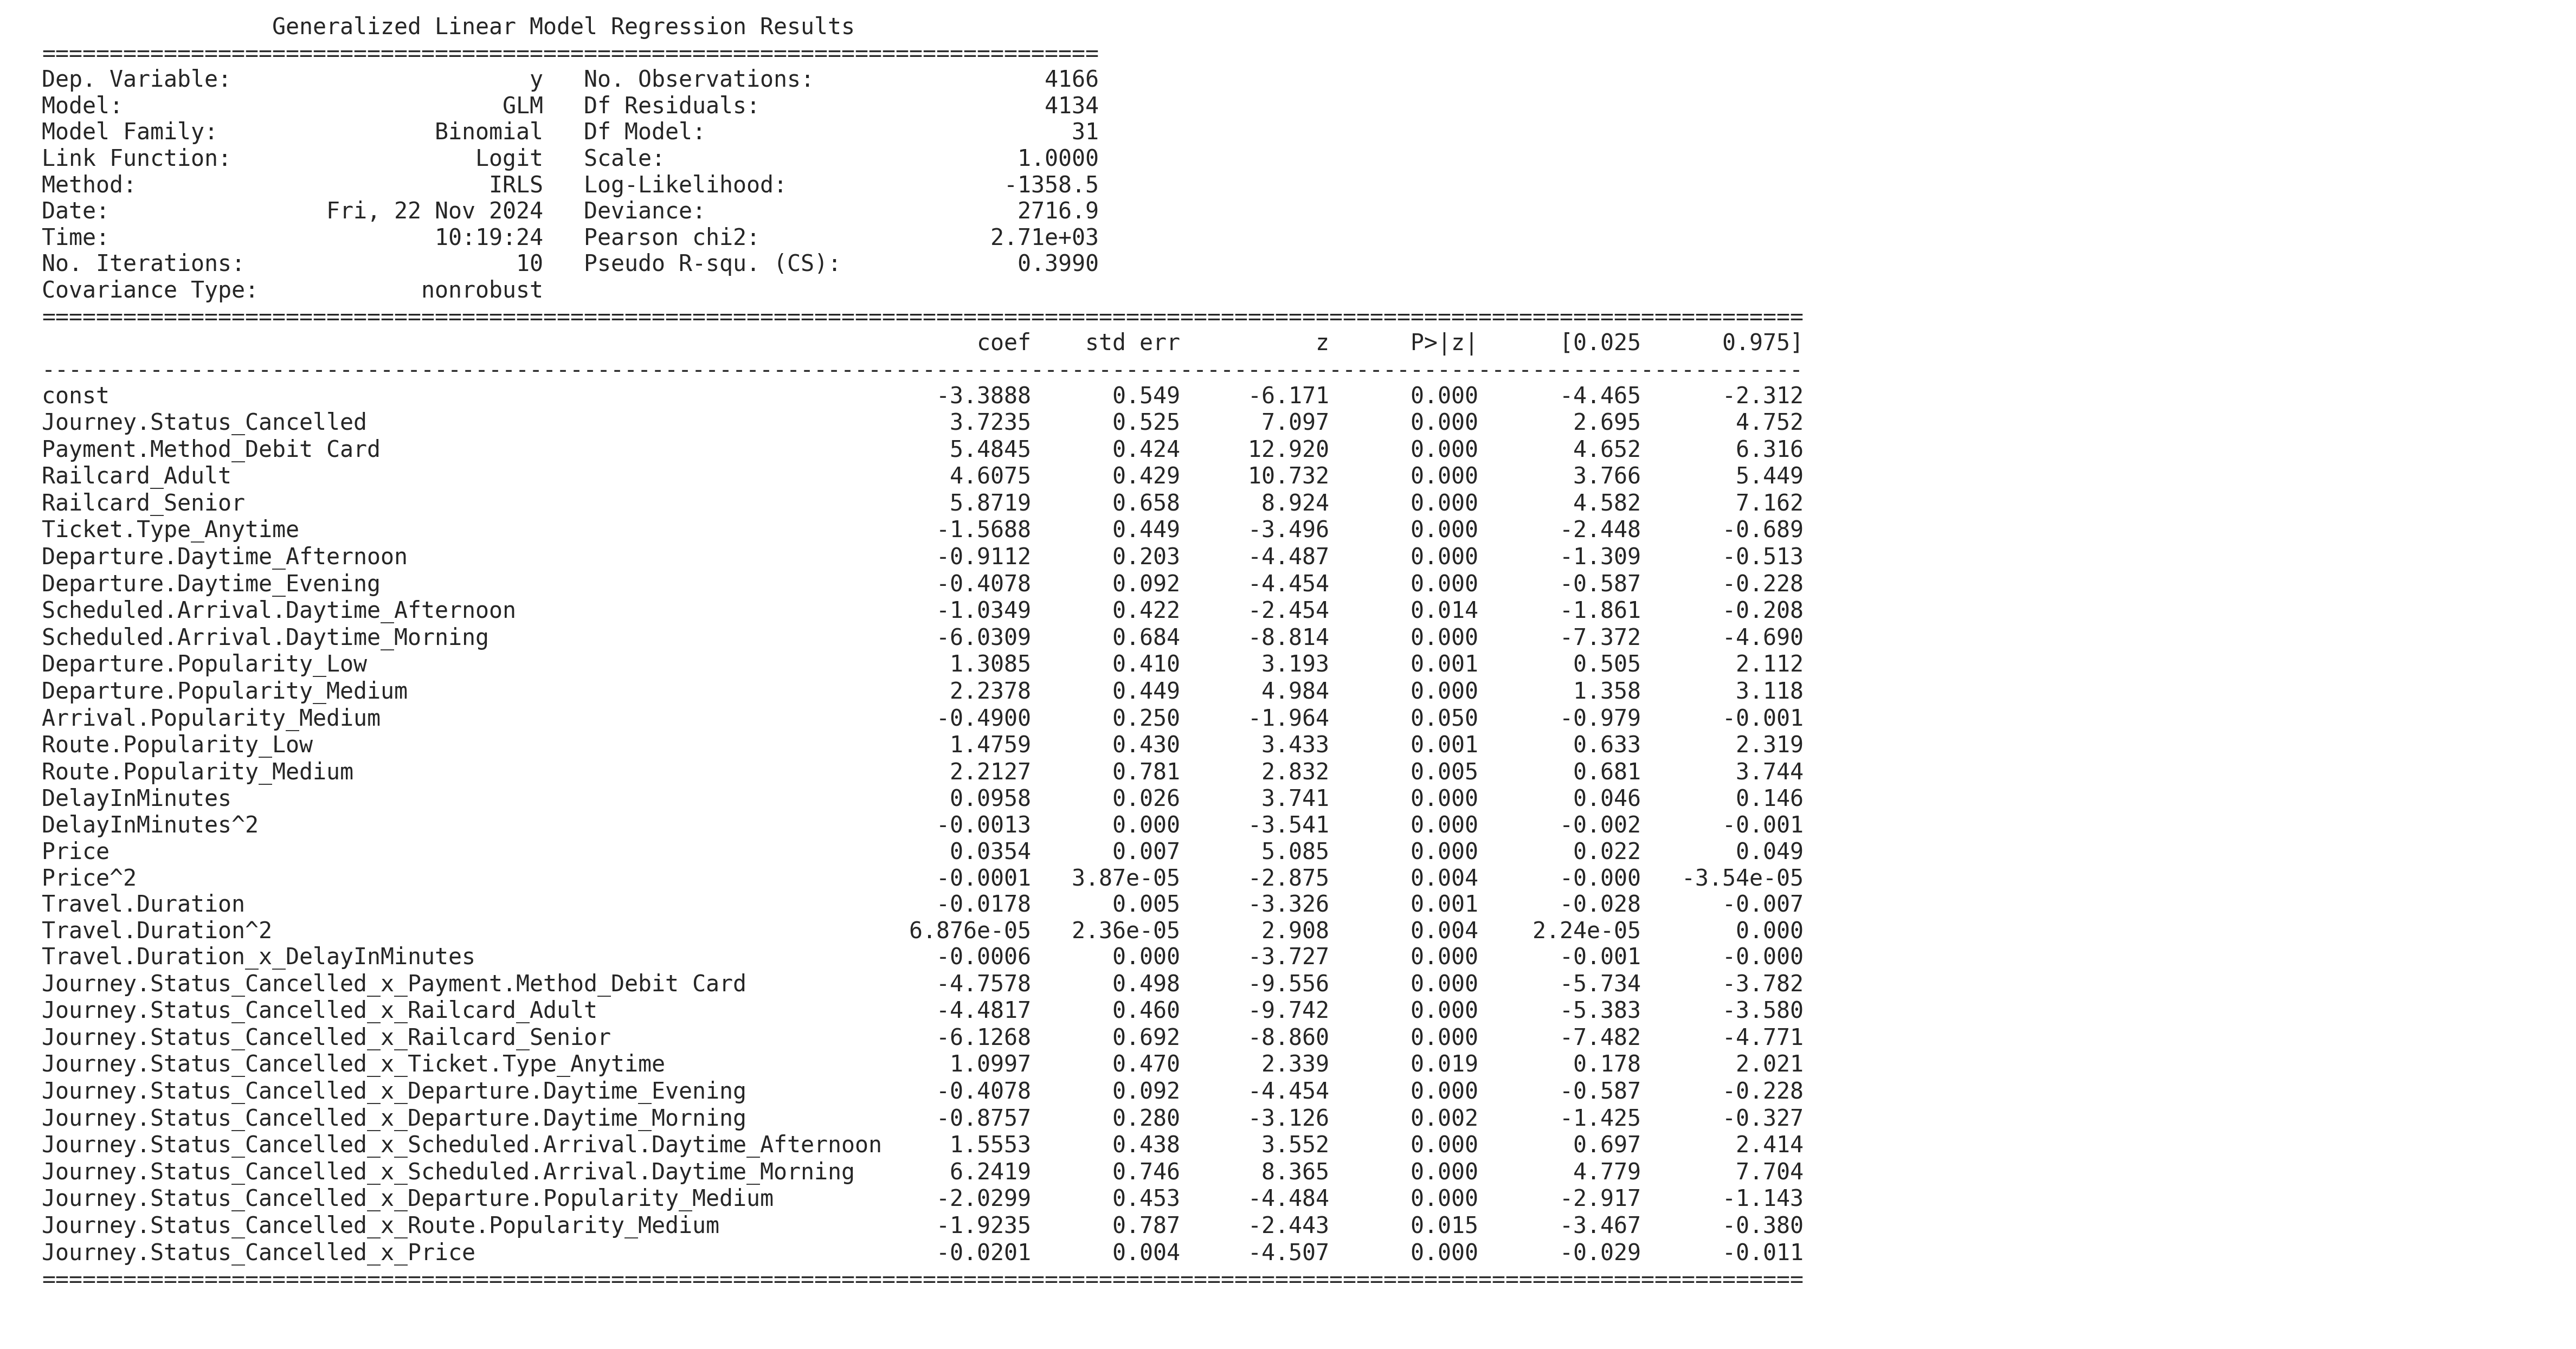

In [2286]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.text(0.01, 0.05, str(glm_bernoulli_m_opt.summary()), {'fontsize': 10}, fontproperties = 'monospace')
ax.axis('off')
plt.tight_layout()
plt.savefig('Figures/glm_bernoulli_m_opt.png', dpi = 300, bbox_inches = 'tight')

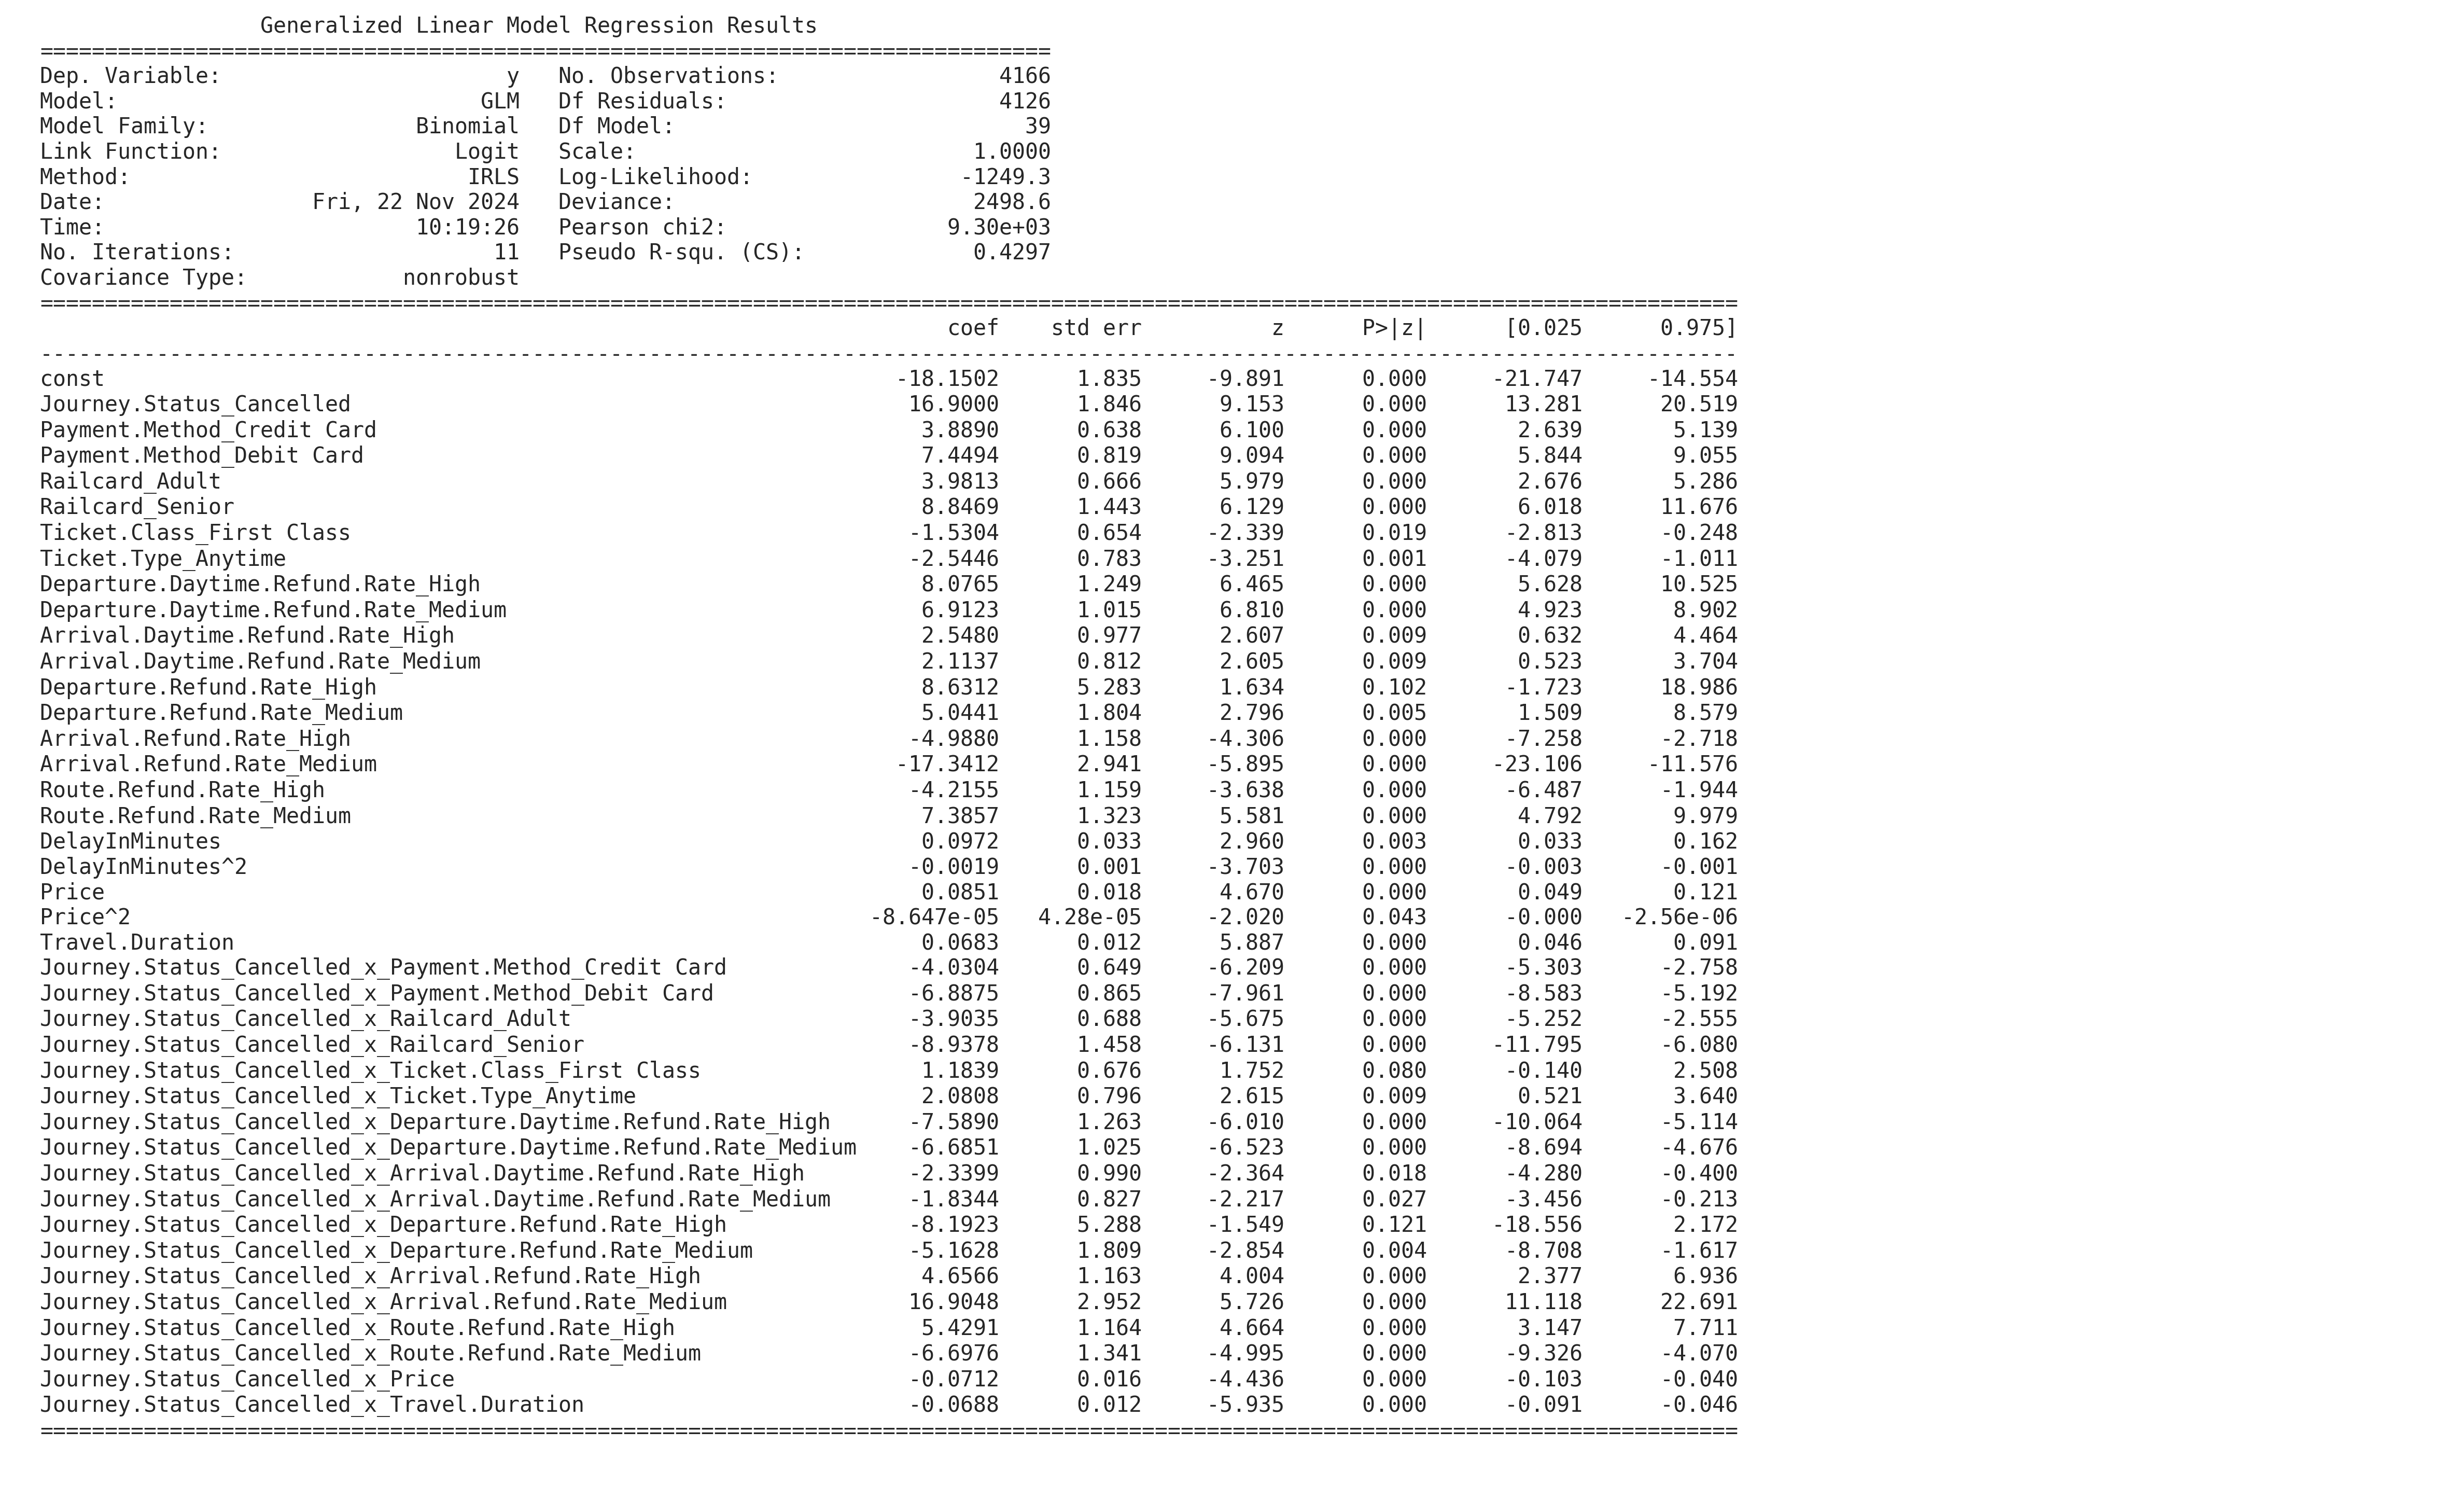

In [2287]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.text(0.01, 0.05, str(glm_bernoulli_m_opt_a.summary()), {'fontsize': 10}, fontproperties = 'monospace')
ax.axis('off')
plt.tight_layout()
plt.savefig('Figures/glm_bernoulli_m_opt_a.png', dpi = 300, bbox_inches = 'tight')